# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Import Data
- Data published in https://www.mdpi.com/2227-9091/9/4/58
- See also https://www.cambridge.org/core/journals/astin-bulletin-journal-of-the-iaa/article/costsensitive-multiclass-adaboost-for-understanding-driving-behavior-based-on-telematics/1E6FD6CA424E5824DC8224B37BF0A7E4

The synthetic datafile contains a total of 52 variables, which can be categorized into three main groups: 

    1. 11 traditional features
    2. 39 telematics features
    3. 2 response variables describing number of claims and aggregated amount of claims
    
The portfolio emulation was based on a real dataset acquired from a Canadian-based insurer, which offered a UBI program that was launched in 2013, to its automobile insurance policyholders. The observation period was for the years between 2013 and 2016, with over 70,000 policies being observed, for which the dataset drawn is pre-engineered for training a statistical model for predictive purposes.

The data generation of the synthetic portfolio of 100,000 drivers is a three-stage process using the feedforward neural networks to perform the two simulations and using extended SMOTE to reproduce the feature space. In the first stage, a synthetic portfolio of the space of feature variables is generated applying an extended SMOTE algorithm. The second stage is simulating values for the number of claims as multiple binary classifications while using feedforward neural networks. The third stage is simulating values for amount of claims as a regression using feedforward neural network with number of claims treated as one of the feature variables. The final synthetic data is created by combining the synthetic portfolio, the synthetic number of claims, and the synthetic amount of claims. The resulting data generation is evaluated with a comparison between the synthetic data and the real data when Poisson and gamma regression models are fitted to the respective data. 

In [2]:
df = pd.read_csv("../data/telematics_original.csv")

In [3]:
df.columns

Index(['Duration', 'Insured.age', 'Insured.sex', 'Car.age', 'Marital',
       'Car.use', 'Credit.score', 'Region', 'Annual.miles.drive',
       'Years.noclaims', 'Territory', 'Annual.pct.driven',
       'Total.miles.driven', 'Pct.drive.mon', 'Pct.drive.tue', 'Pct.drive.wed',
       'Pct.drive.thr', 'Pct.drive.fri', 'Pct.drive.sat', 'Pct.drive.sun',
       'Pct.drive.2hrs', 'Pct.drive.3hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday',
       'Pct.drive.wkend', 'Pct.drive.rush am', 'Pct.drive.rush pm',
       'Avgdays.week', 'Accel.06miles', 'Accel.08miles', 'Accel.09miles',
       'Accel.11miles', 'Accel.12miles', 'Accel.14miles', 'Brake.06miles',
       'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 'Brake.12miles',
       'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity09',
       'Left.turn.intensity10', 'Left.turn.intensity11',
       'Left.turn.intensity12', 'Right.turn.intensity08',
       'Right.turn.intensity09', 'Right.turn.intensity10',
       'Right.turn.intensity1

# EDA

- Duration: Duration of the insurance coverage of a given policy, in days.

In [4]:
df['Duration'].describe()

count   100000.000
mean       314.204
std         79.746
min         27.000
25%        200.000
50%        365.000
75%        366.000
max        366.000
Name: Duration, dtype: float64

In [5]:
df['Duration'].value_counts().head(5)

Duration
365    36741
366    29615
184     7173
183     6526
182     6269
Name: count, dtype: int64

In [6]:
# Leap year in 2016 likely explains the contracts for 366
sum(df['Duration']==366) 
# Approximately 30% of the portfolio

29615

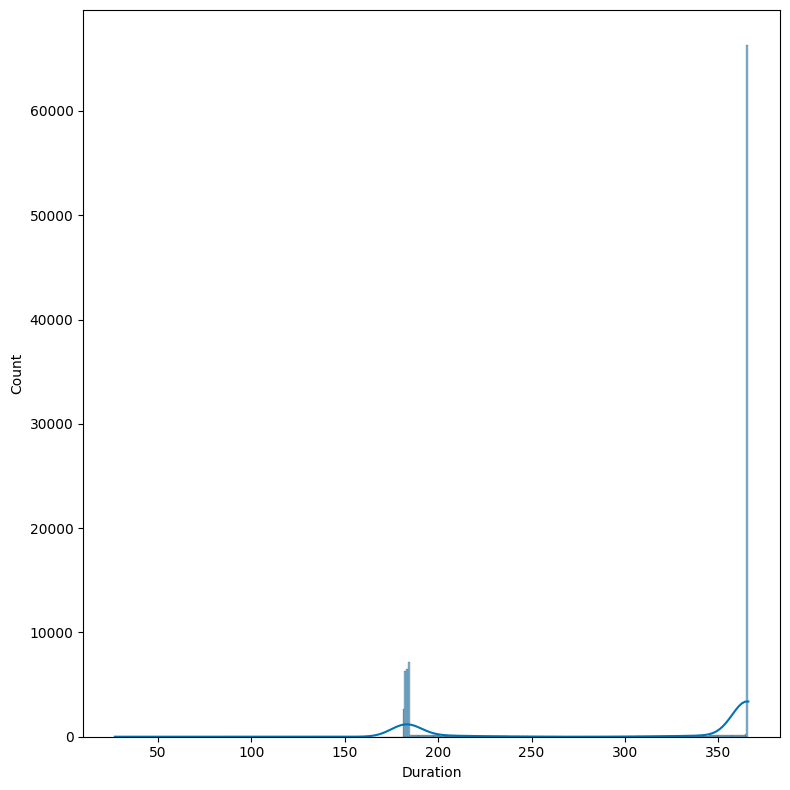

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
unique_values = np.arange(df['Duration'].min(), df['Duration'].max() + 1)
sns.histplot(ax=ax, data=df, x='Duration', bins=unique_values, kde=True)
ax.set_xlabel("Duration")
ax.set_ylabel("Count")
fig.tight_layout()
plt.show()

- Insured.age: Age of insured driver, in years.

Canada's driving age is determined on a province-by-province basis.

| Province | Learner's Permit | Restricted License | Full License | Notes |
| :- | :- | :- | :- | :- |
| Alberta | 14 | 16 | 18 |
| British Columbia | 16 | 17 | 19 | Restricted licence stage can be shortened from two years to one year and six months if driver goes through an accredited driver education program. |
| Manitoba | 16 | 16.9 | 18 | Learner's permit can be acquired at 15 years and 6 months if student uses an accredited high school driver education program. |
| New Brunswick | 16 | 17 | 18 | |
| Newfoundland & Labrador | 16 | 17 | 18 | |
| Nova Scotia | 16 | 17 | 19 | |
| Ontario | 16 | 17 | 18 | |
| Prince Edward Island | 16 | 17 | 19 | |
| Saskatchewan | 16 | 16.9 | 18 | Learner's permit can be acquired at 15 years of age if student uses an accredited high school driver education program. |
| Quebec | 16 | 17 | 19 | |

In [8]:
df['Insured.age'].describe()

count   100000.000
mean        51.379
std         15.467
min         16.000
25%         39.000
50%         51.000
75%         63.000
max        103.000
Name: Insured.age, dtype: float64

In [9]:
# Drivers under or equal to the max-min age a Full License can be obtained
df[df['Insured.age']<=19]["Insured.age"].value_counts()

Insured.age
19    121
18     40
17     12
16      4
Name: count, dtype: int64

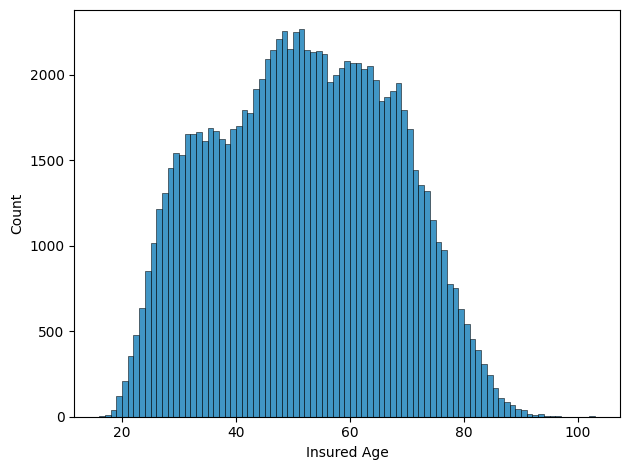

In [10]:
fig, ax = plt.subplots()#figsize=(8, 8))
unique_values = np.arange(df['Insured.age'].min(), df['Insured.age'].max() + 1)
sns.histplot(ax=ax, data=df, x='Insured.age', bins=unique_values, kde=False)
#ax.axvline(x=19, color="red", label="Full License")
ax.set_xlabel("Insured Age")
ax.set_ylabel("Count")
fig.tight_layout()
#ax.legend()
plt.savefig("../eda_figures/insured_age.png")
#plt.show()

- Insured.sex: Sex of insured driver (Male/Female).

In [11]:
df['Insured.sex'].describe()

count     100000
unique         2
top         Male
freq       53943
Name: Insured.sex, dtype: object

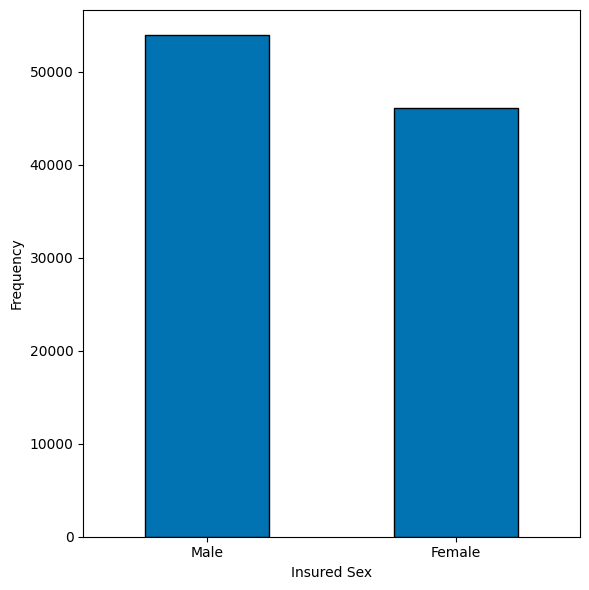

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
df['Insured.sex'].value_counts().plot(ax = ax, kind = 'bar', xlabel="Insured Sex", ylabel = 'Frequency', rot=0, edgecolor='black')
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/insured_sex.png")

In [13]:
df['Insured.sex'].value_counts()/df.shape[0]

Insured.sex
Male     0.539
Female   0.461
Name: count, dtype: float64

- Car.age: Age of vehicle, in years.

Negative values due to buying car in advance 

In [14]:
df['Car.age'].describe()

count   100000.000
mean         5.640
std          4.062
min         -2.000
25%          2.000
50%          5.000
75%          8.000
max         20.000
Name: Car.age, dtype: float64

In [15]:
# Number of cars with negative age
sum(df['Car.age']<0)

1942

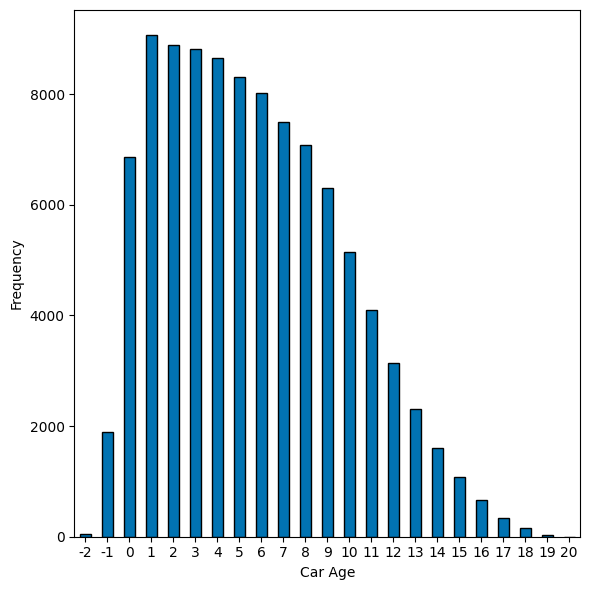

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
df['Car.age'].value_counts().sort_index().plot(ax = ax, kind = 'bar', xlabel="Car Age", ylabel = 'Frequency', rot=0, edgecolor='black')
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/car_age.png")

- Marital: Martial status (Single/Married).

In [17]:
df['Marital'].describe()

count      100000
unique          2
top       Married
freq        69930
Name: Marital, dtype: object

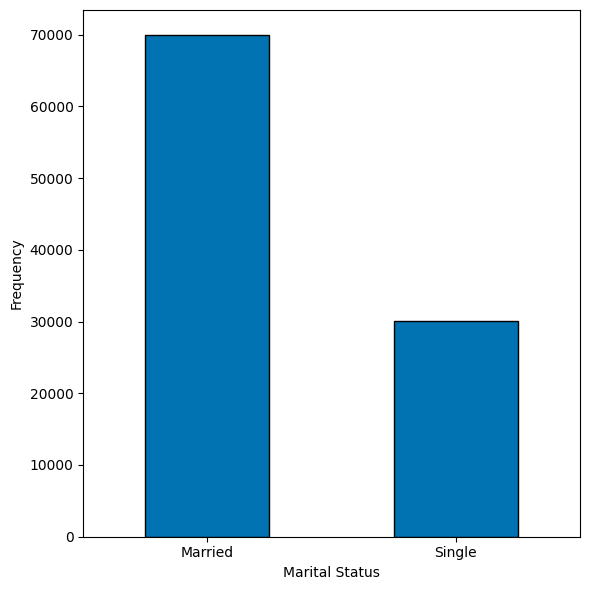

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
df['Marital'].value_counts().plot(ax = ax, kind = 'bar', xlabel="Marital Status", ylabel = 'Frequency', rot=0, edgecolor='black')
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/marital.png")

In [19]:
df['Marital'].value_counts() / df.shape[0]

Marital
Married   0.699
Single    0.301
Name: count, dtype: float64

- Car.use: Use of vehicle: Private, Commute, Farmer, Commercial.

In [20]:
df['Car.use'].describe()

count      100000
unique          4
top       Commute
freq        49815
Name: Car.use, dtype: object

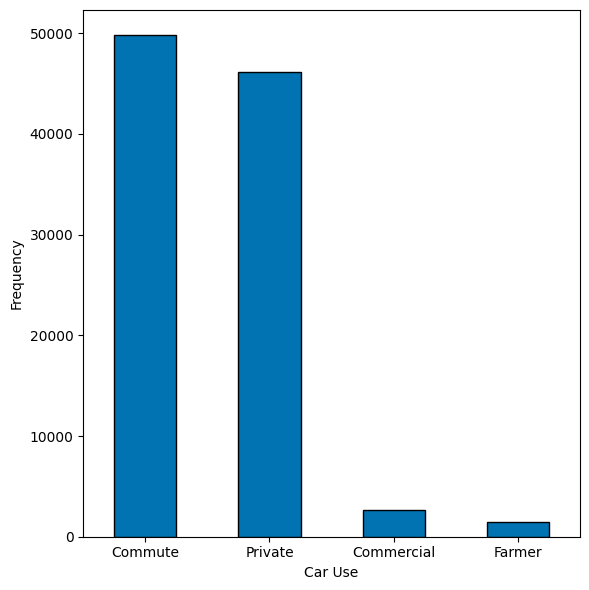

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
df['Car.use'].value_counts().plot(ax = ax, kind = 'bar', xlabel="Car Use", ylabel = 'Frequency', rot=0, edgecolor='black')
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/car_use.png")

In [22]:
df['Car.use'].value_counts()/100000

Car.use
Commute      0.498
Private      0.461
Commercial   0.026
Farmer       0.014
Name: count, dtype: float64

- Credit.score: Credit score of insured driver.

There are two main credit bureaus in Canada: Equifax and TransUnion. A credit score is a number, generally between 300 and 900, that helps determine creditworthiness. The higher your score, the better the credit rating. Although credit scoring models vary, generally, credit scores from 660 to 724 are considered good; 725 to 759 are considered very good; and 760 and up are considered excellent. The average Canadian credit score is likely around 650.

In [23]:
df['Credit.score'].describe()

count   100000.000
mean       800.889
std         83.382
min        422.000
25%        766.000
50%        825.000
75%        856.000
max        900.000
Name: Credit.score, dtype: float64

In [24]:
print("Poor Credit Score in [300,559]: "+str(round(100*sum(df['Credit.score'].between(300,559))/len(df),2))+"%")
print("Fair Credit Score in [560,659]: "+str(round(100*sum(df['Credit.score'].between(560,659))/len(df),2))+"%")
print("Good Credit Score in [660,724]: "+str(round(100*sum(df['Credit.score'].between(660,724))/len(df),2))+"%")
print("Very Good Credit Score in [725,759]: "+str(round(100*sum(df['Credit.score'].between(725,759))/len(df),2))+"%")
print("Excellent Credit Score in [760,900]: "+str(round(100*sum(df['Credit.score'].between(760,900))/len(df),2))+"%")

Poor Credit Score in [300,559]: 1.81%
Fair Credit Score in [560,659]: 5.77%
Good Credit Score in [660,724]: 8.8%
Very Good Credit Score in [725,759]: 7.23%
Excellent Credit Score in [760,900]: 76.39%


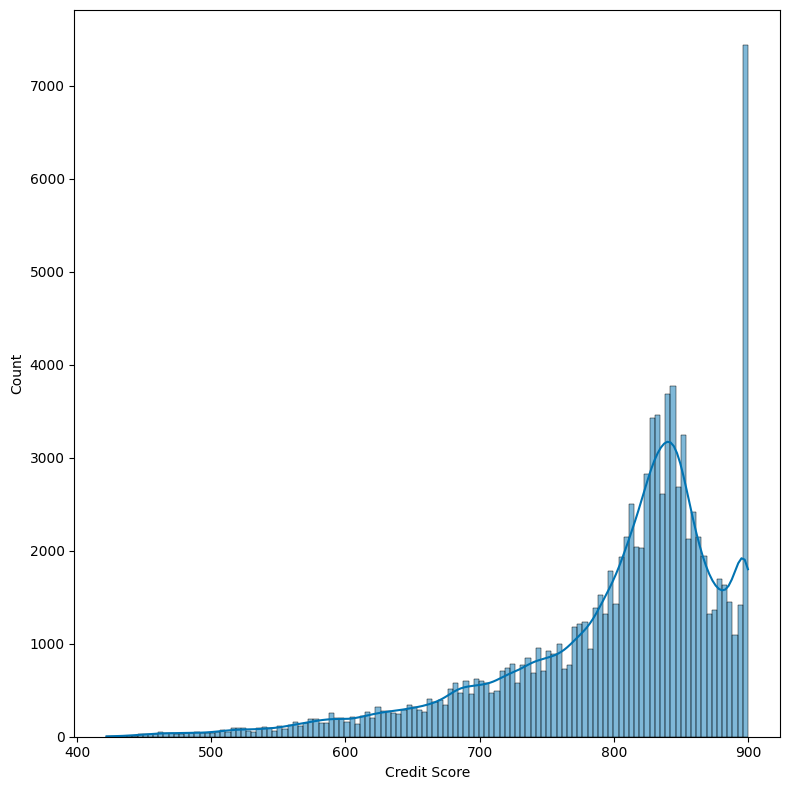

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(ax=ax, data=df, x='Credit.score', kde=True)
ax.set_xlabel("Credit Score")
ax.set_ylabel("Count")
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/credit_score.png")

In [26]:
bins = [300, 559, 659, 724, 759, 900]
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

# Create a new column for the credit score bands
credit_score_categories = df[['Credit.score']].copy()
credit_score_categories['Credit.score.band'] = pd.cut(credit_score_categories['Credit.score'], bins=bins, labels=labels, right=False)
credit_score_categories = credit_score_categories.groupby('Credit.score.band').size().reset_index(name='Count')

/var/folders/kb/rz2pm09x1jzbrrpsy5ffp3cc0000gn/T/ipykernel_6062/2386598563.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credit_score_categories = credit_score_categories.groupby('Credit.score.band').size().reset_index(name='Count')


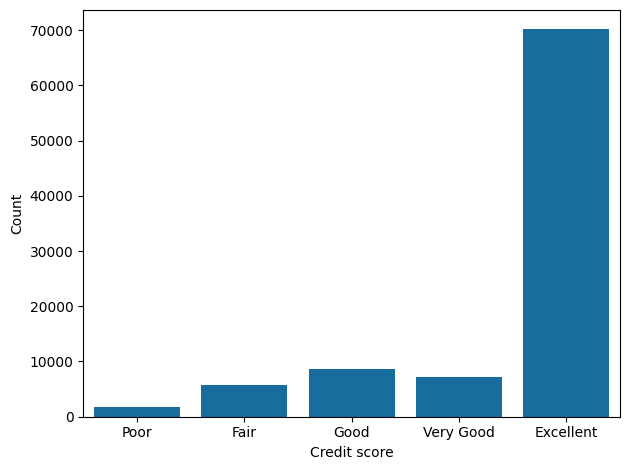

In [28]:
fig, ax = plt.subplots()#figsize=(8, 8))
sns.barplot(ax=ax, data=credit_score_categories, x='Credit.score.band', y='Count')#bins=[300, 560, 660, 725, 760, 900], kde=False)
#ax.axvline(x=19, color="red", label="Full License")
ax.set_xlabel("Credit score")
ax.set_ylabel("Count")
fig.tight_layout()
#ax.legend()
plt.savefig("../eda_figures/credit_score_categories.png")
#plt.show()

In [29]:
df[df['Credit.score']==900]

Duration  Insured.age Insured.sex  Car.age  Marital  Car.use  \
20          365           64      Female        9  Married  Private   
22          366           65      Female        0  Married  Private   
52          365           64        Male        3  Married  Private   
76          366           70        Male        5  Married  Private   
104         183           75        Male        6  Married  Private   
...         ...          ...         ...      ...      ...      ...   
99910       366           44      Female       17   Single  Commute   
99928       182           58        Male       11  Married  Private   
99933       357           77      Female        3  Married  Private   
99935       183           52        Male        5   Single  Commute   
99937       182           66      Female        4  Married  Commute   

       Credit.score Region  Annual.miles.drive  Years.noclaims  ...  \
20          900.000  Urban            6213.710              44  ...   
22          900.000  Urban            9320.565              48  ...   
52          900.000  Rural           15534.275              48  ...   
76          900.000  Urban            6213.710              51  ...   
104         900.000  Urban            6213.710              58  ...   
...             ...    ...                 ...             ...  ...   
99910       900.000  Urban            6213.710              26  ...   
99928       900.000  Urban            6213.710              42  ...   
99933       900.000  Urban            9320.565              30  ...   
99935       900.000  Urban           12427.420              32  ...   
99937       900.000  Urban            6213.710              25  ...   

       Left.turn.intensity10  Left.turn.intensity11  Left.turn.intensity12  \
20                     0.000                  0.000                  0.000   
22                     0.000                  0.000                  0.000   
52                     0.000                  0.000                  0.000   
76                     6.000                  2.000                  1.000   
104                    6.000                  2.000                  0.000   
...                      ...                    ...                    ...   
99910                  0.000                  0.000                  0.000   
99928                  2.000                  0.000                  0.000   
99933                  3.000                  2.000                  0.000   
99935                  0.000                  0.000                  0.000   
99937                 53.000                 21.000                  7.000   

       Right.turn.intensity08  Right.turn.intensity09  Right.turn.intensity10  \
20                      6.000                   3.000                   0.000   
22                     16.000                   6.000                   0.000   
52                      0.000                   0.000                   0.000   
76                    582.000                 291.000                  65.000   
104                    32.000                  12.000                   2.000   
...                       ...                     ...                     ...   
99910                   4.000                   1.000                   0.000   
99928                 198.000                  90.000                  18.000   
99933                 349.000                 124.000                  14.000   
99935                   8.000                   4.000                   2.000   
99937                1783.000                1062.000                 390.000   

       Right.turn.intensity11  Right.turn.intensity12  NB_Claim  AMT_Claim  
20                      0.000                   0.000         0      0.000  
22                      0.000                   0.000         0      0.000  
52                      0.000                   0.000         0      0.000  
76                     24.000                   9.000         0      0.000  
104   

- Region: Type of region where driver lives: rural, urban.

In [30]:
df['Region'].describe()

count     100000
unique         2
top        Urban
freq       78141
Name: Region, dtype: object

In [31]:
print("Urban: "+str(round(sum(df['Region']=="Urban")/len(df)*100,2))+"%")
print("Rural: "+str(round(sum(df['Region']=="Rural")/len(df)*100,2))+"%")

Urban: 78.14%
Rural: 21.86%


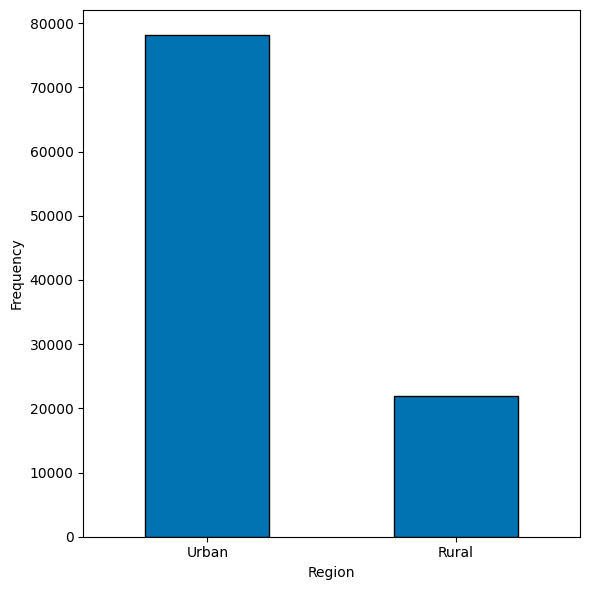

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
df['Region'].value_counts().plot(ax = ax, kind = 'bar', xlabel="Region", ylabel = 'Frequency', rot=0, edgecolor='black')
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/region.png")

- Annual.miles.drive: Annual miles expected to be driven declared by driver.

In [33]:
df['Annual.miles.drive'].describe()

count   100000.000
mean      9124.123
std       3826.145
min          0.000
25%       6213.710
50%       7456.452
75%      12427.420
max      56731.172
Name: Annual.miles.drive, dtype: float64

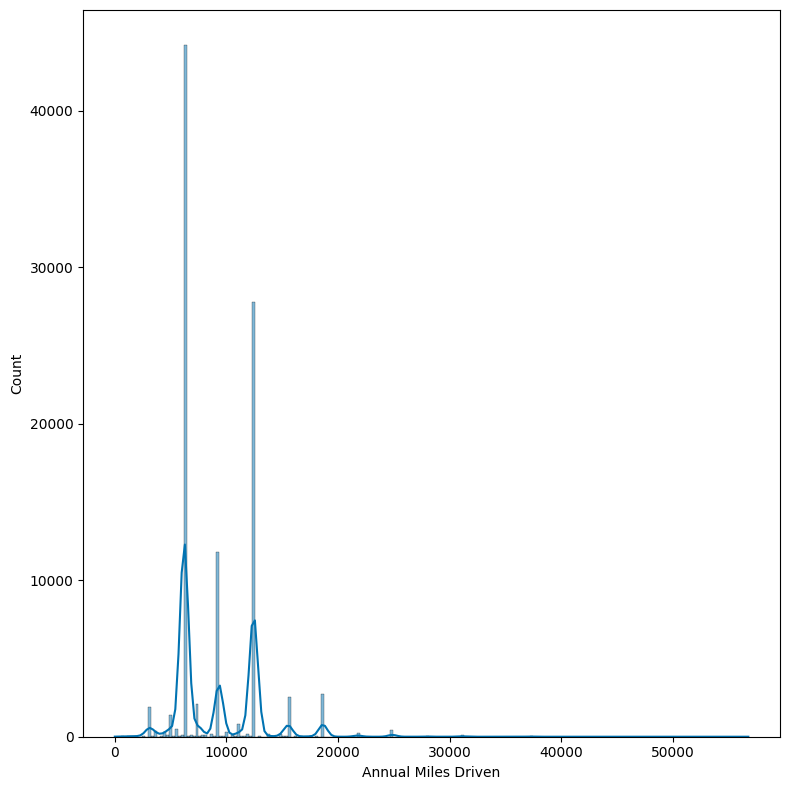

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(ax=ax, data=df, x='Annual.miles.drive', kde=True)
ax.set_xlabel("Annual Miles Driven")
ax.set_ylabel("Count")
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/annual_miles_driven.png")

In [35]:
# Only 325 unique values. Since this is declared by the driver, they are likely rounding up to the nearest hundred/thousand
df['Annual.miles.drive'].nunique()

325

In [36]:
# Here we see a lot of people select the same value which appears 'odd' until we convert from miles to km
df['Annual.miles.drive'].value_counts().head(5)

Annual.miles.drive
6213.710     44159
12427.420    27736
9320.565     11760
18641.130     2741
15534.275     2497
Name: count, dtype: int64

In [37]:
round(df['Annual.miles.drive']*1.609344).value_counts().head(5)

Annual.miles.drive
10000.000    44159
20000.000    27736
15000.000    11760
30000.000     2741
25000.000     2497
Name: count, dtype: int64

- Years.noclaims: Number of years without at claims.

In [38]:
df['Years.noclaims'].describe()

count   100000.000
mean        28.840
std         16.124
min          0.000
25%         15.000
50%         29.000
75%         41.000
max         79.000
Name: Years.noclaims, dtype: float64

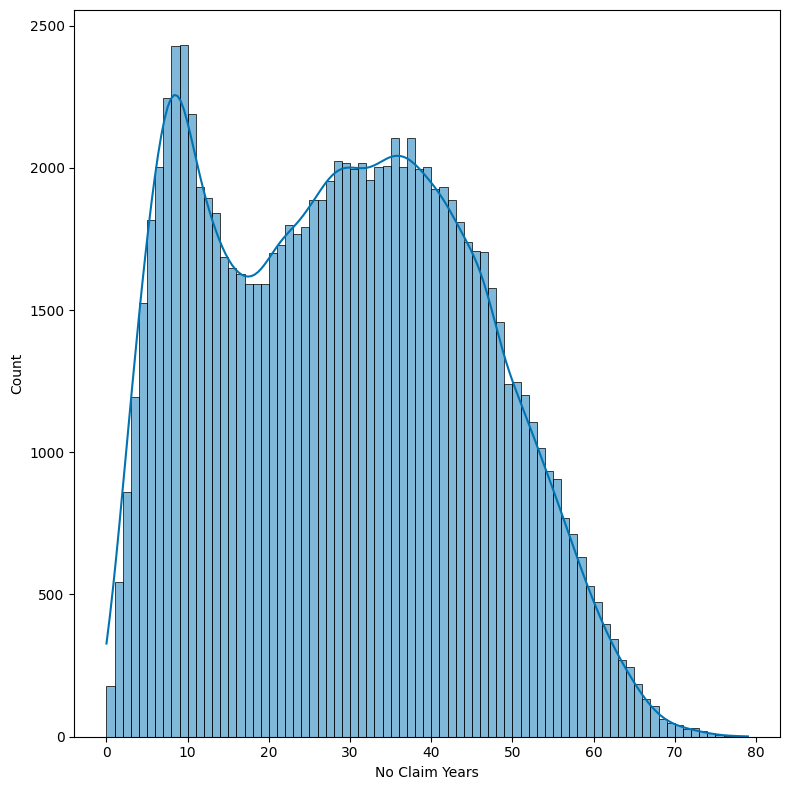

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
unique_values = np.arange(df['Years.noclaims'].min(), df['Years.noclaims'].max() + 1)
sns.histplot(ax=ax, data=df, x='Years.noclaims', bins=unique_values, kde=True)
ax.set_xlabel("No Claim Years")
ax.set_ylabel("Count")
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/years_noclaims.png")

- Territory: Territorial location of vehicle.

In [40]:
df['Territory'].describe()

count   100000.000
mean        56.531
std         24.037
min         11.000
25%         35.000
50%         62.000
75%         78.000
max         91.000
Name: Territory, dtype: float64

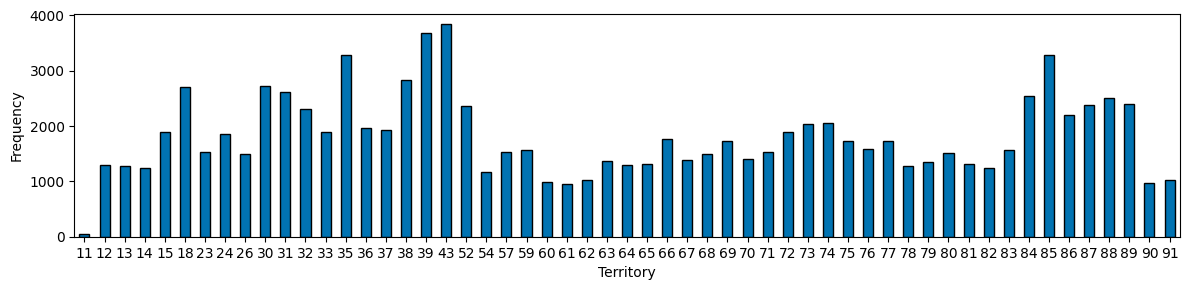

In [41]:
fig, ax = plt.subplots(figsize=(12, 3))
df['Territory'].value_counts().sort_index().plot(ax = ax, kind = 'bar', xlabel="Territory", ylabel = 'Frequency', rot=0, edgecolor='black')
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/territory.png")

In [42]:
df['Territory'].nunique()

55

In [43]:
df['Territory'].value_counts()

Territory
43    3842
39    3686
85    3288
35    3279
38    2839
30    2716
18    2710
31    2612
84    2552
88    2511
89    2404
87    2372
52    2366
32    2307
86    2209
74    2064
73    2035
36    1962
37    1938
33    1893
72    1891
15    1885
24    1865
66    1770
75    1733
77    1733
69    1731
76    1585
83    1569
59    1562
23    1533
71    1532
57    1530
80    1505
26    1504
68    1499
70    1406
67    1379
63    1365
79    1357
65    1320
81    1320
64    1304
12    1296
78    1287
13    1277
14    1245
82    1234
54    1175
62    1034
91    1034
60     987
90     972
61     944
11      52
Name: count, dtype: int64

In [44]:
df['Territory'].nunique()

55

- Annual.pct.driven: Annualized percentage of time on the road. This is the number of days a policyholder uses vehicle divided by 365.

In [45]:
df['Annual.pct.driven'].describe()

count   100000.000
mean         0.502
std          0.299
min          0.003
25%          0.249
50%          0.490
75%          0.753
max          1.000
Name: Annual.pct.driven, dtype: float64

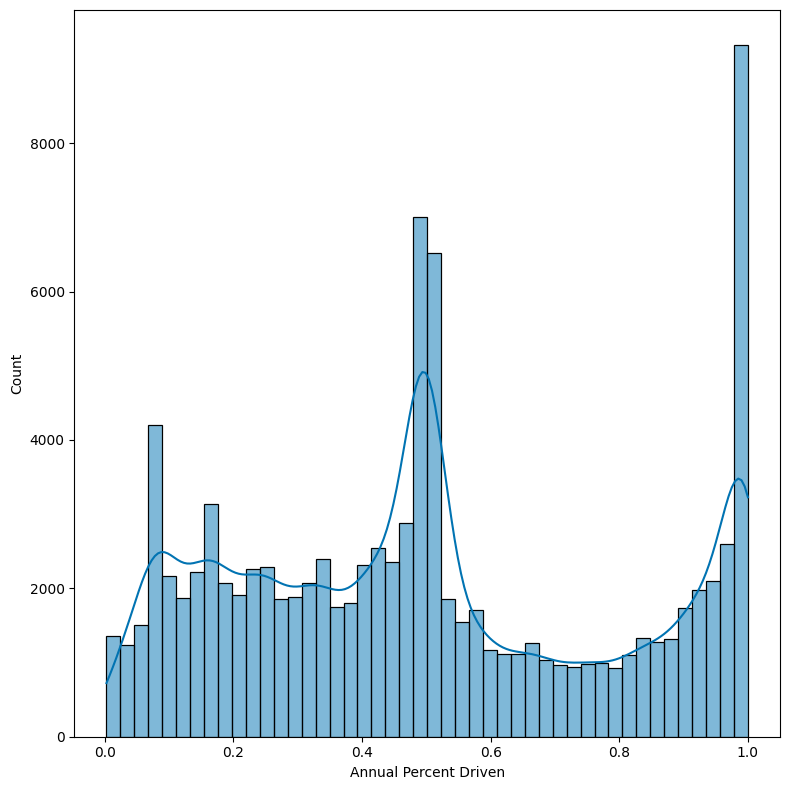

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(ax=ax, data=df, x='Annual.pct.driven', kde=True)
ax.set_xlabel("Annual Percent Driven")
ax.set_ylabel("Count")
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/annual_pct_driven.png")

In [47]:
# Top 5 most freqeunt answers
(365*df['Annual.pct.driven']).value_counts().head(5)

Annual.pct.driven
365.000    5568
182.000    2425
183.000    2401
184.000    2134
181.000    1573
Name: count, dtype: int64

In [48]:
365*df['Annual.pct.driven'].describe()

count   36500000.000
mean         183.337
std          109.204
min            1.000
25%           91.000
50%          179.000
75%          275.000
max          365.000
Name: Annual.pct.driven, dtype: float64

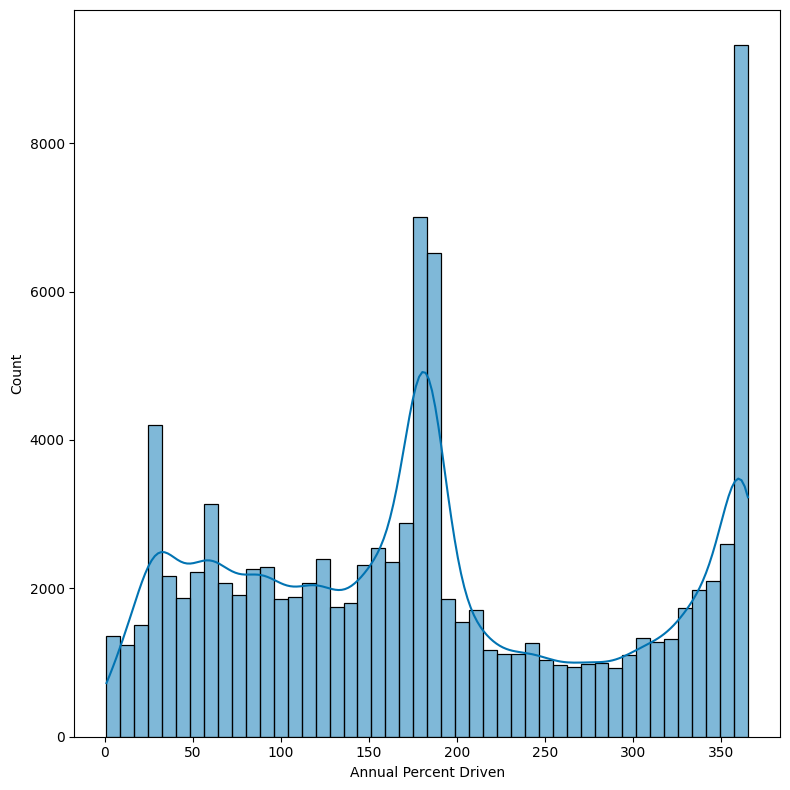

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(ax=ax, data=df*365, x='Annual.pct.driven', kde=True)
ax.set_xlabel("Annual Percent Driven")
ax.set_ylabel("Count")
fig.tight_layout()
plt.show()

- Total.miles.driven: Total distance driven in miles.

In [50]:
sum(df['Total.miles.driven']<20000)/100000

0.98853

In [51]:
df['Total.miles.driven'].describe()

count   100000.000
mean      4833.575
std       4545.943
min          0.095
25%       1529.897
50%       3468.288
75%       6779.877
max      47282.604
Name: Total.miles.driven, dtype: float64

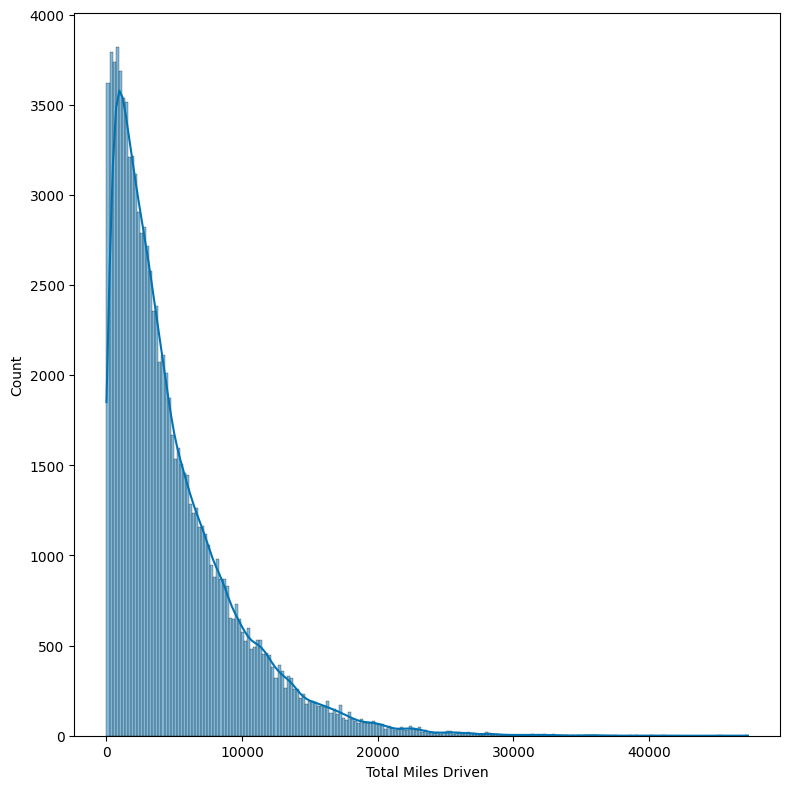

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(ax=ax, data=df, x='Total.miles.driven', kde=True)
ax.set_xlabel("Total Miles Driven")
ax.set_ylabel("Count")
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/total_miles_driven.png")

- Pct.drive.xxx: Percentage of driving day xxx of the week: mon/tue/wed/thr/fri/sat/sun.

These are compositional, i.e. Sum(Pct.drive.xxx) = 1

In [53]:
df[['Pct.drive.mon','Pct.drive.tue','Pct.drive.wed','Pct.drive.thr','Pct.drive.fri','Pct.drive.sat','Pct.drive.sun']].describe()

Pct.drive.mon  Pct.drive.tue  Pct.drive.wed  Pct.drive.thr  \
count     100000.000     100000.000     100000.000     100000.000   
mean           0.139          0.151          0.148          0.153   
std            0.043          0.048          0.045          0.044   
min            0.000          0.000          0.000          0.000   
25%            0.121          0.130          0.129          0.134   
50%            0.138          0.148          0.147          0.151   
75%            0.155          0.168          0.166          0.171   
max            0.998          1.000          1.000          0.998   

       Pct.drive.fri  Pct.drive.sat  Pct.drive.sun  
count     100000.000     100000.000     100000.000  
mean           0.158          0.138          0.113  
std            0.044          0.053          0.050  
min            0.000          0.000         -0.000  
25%            0.139          0.109          0.085  
50%            0.156          0.135          0.111  
75%            0.174          0.161          0.135  
max            0.999          0.947          0.976

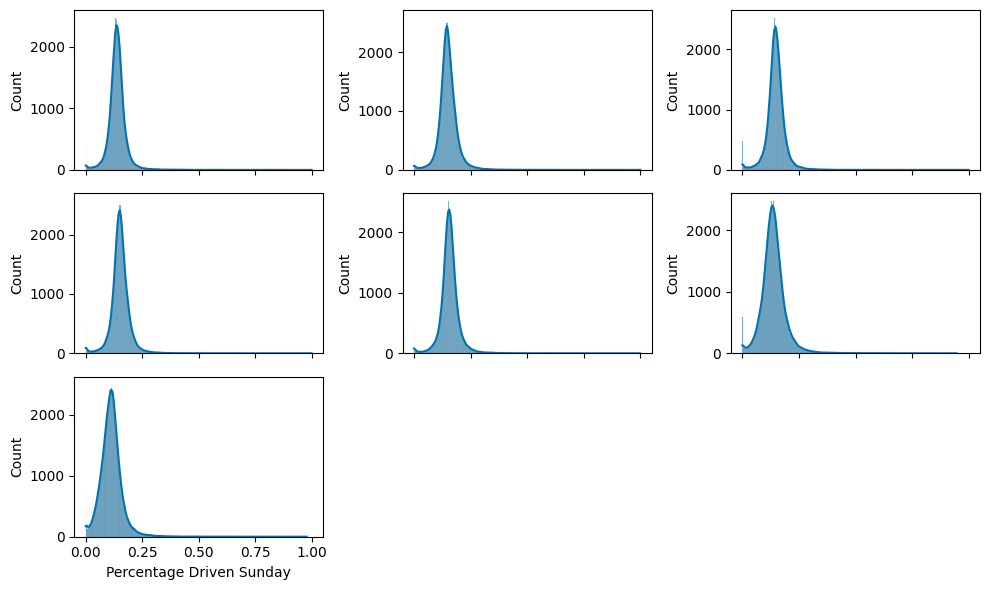

In [54]:
fig, axs = plt.subplots(3,3,figsize=(10, 6), sharex=True)

sns.histplot(ax=axs[0,0], data=df, x='Pct.drive.mon', kde=True)
axs[0,0].set_xlabel("Percentage Driven Monday")
axs[0,0].set_ylabel("Count")

sns.histplot(ax=axs[0,1], data=df, x='Pct.drive.tue', kde=True)
axs[0,1].set_xlabel("Percentage Driven Tuesday")
axs[0,1].set_ylabel("Count")

sns.histplot(ax=axs[0,2], data=df, x='Pct.drive.wed', kde=True)
axs[0,2].set_xlabel("Percentage Driven Wednesday")
axs[0,2].set_ylabel("Count")

sns.histplot(ax=axs[1,0], data=df, x='Pct.drive.thr', kde=True)
axs[1,0].set_xlabel("Percentage Driven Thursday")
axs[1,0].set_ylabel("Count")

sns.histplot(ax=axs[1,1], data=df, x='Pct.drive.fri', kde=True)
axs[1,1].set_xlabel("Percentage Driven Friday")
axs[1,1].set_ylabel("Count")

sns.histplot(ax=axs[1,2], data=df, x='Pct.drive.sat', kde=True)
axs[1,2].set_xlabel("Percentage Driven Saturday")
axs[1,2].set_ylabel("Count")

sns.histplot(ax=axs[2,0], data=df, x='Pct.drive.sun', kde=True)
axs[2,0].set_xlabel("Percentage Driven Sunday")
axs[2,0].set_ylabel("Count")

fig.delaxes(ax=axs[2,1])
fig.delaxes(ax=axs[2,2])

fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/percentage_driven_day.png")

In [55]:
df[["Pct.drive.wkday", "Pct.drive.mon", "Pct.drive.tue", "Pct.drive.wed", "Pct.drive.thr", "Pct.drive.fri", "Pct.drive.sat", "Pct.drive.sun", "Pct.drive.wkend"]].corr().style.background_gradient(cmap='coolwarm', axis=None)

- Pct.drive.xhrs: Percentage vehicle driven within x hrs: 2hrs/3hrs/4hrs.

Not compositional. 

Pct.drive.2hrs >= Pct.drive.3hrs >= Pct.drive.4hrs

In [56]:
df[['Pct.drive.2hrs','Pct.drive.3hrs','Pct.drive.4hrs']].describe()

Pct.drive.2hrs  Pct.drive.3hrs  Pct.drive.4hrs
count      100000.000      100000.000      100000.000
mean            0.004           0.001           0.000
std             0.008           0.004           0.003
min             0.000           0.000           0.000
25%             0.000           0.000           0.000
50%             0.001           0.000           0.000
75%             0.005           0.001           0.000
max             0.456           0.324           0.266

In [57]:
print((df['Pct.drive.2hrs'] >= df['Pct.drive.3hrs']).all())
print((df['Pct.drive.2hrs'] >= df['Pct.drive.4hrs']).all())
print((df['Pct.drive.3hrs'] >= df['Pct.drive.4hrs']).all())

True
True
True


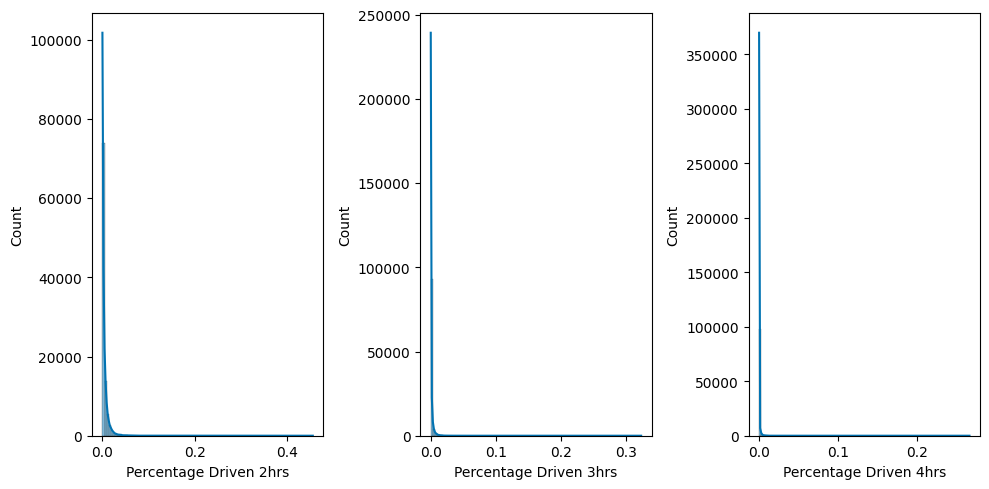

In [58]:
fig, ax = plt.subplots(1,3,figsize=(10, 5))

sns.histplot(ax=ax[0], data=df, x='Pct.drive.2hrs', bins=100, kde=True)
ax[0].set_xlabel("Percentage Driven 2hrs")
ax[0].set_ylabel("Count")

sns.histplot(ax=ax[1], data=df, x='Pct.drive.3hrs', bins=100, kde=True)
ax[1].set_xlabel("Percentage Driven 3hrs")
ax[1].set_ylabel("Count")

sns.histplot(ax=ax[2], data=df, x='Pct.drive.4hrs', bins=100, kde=True)
ax[2].set_xlabel("Percentage Driven 4hrs")
ax[2].set_ylabel("Count")


fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/percentage_driven_hrs.png")

In [59]:
print("Percentage vehicle driven within 2hrs greater than 0.05: "+str(100*sum(df['Pct.drive.2hrs']>=0.05)/len(df))+"%")
print("Percentage vehicle driven within 3hrs greater than 0.02: "+str(100*sum(df['Pct.drive.3hrs']>=0.02)/len(df))+"%")
print("Percentage vehicle driven within 4hrs greater than 0.01: "+str(100*sum(df['Pct.drive.4hrs']>=0.01)/len(df))+"%")

Percentage vehicle driven within 2hrs greater than 0.05: 0.347%
Percentage vehicle driven within 3hrs greater than 0.02: 0.325%
Percentage vehicle driven within 4hrs greater than 0.01: 0.239%


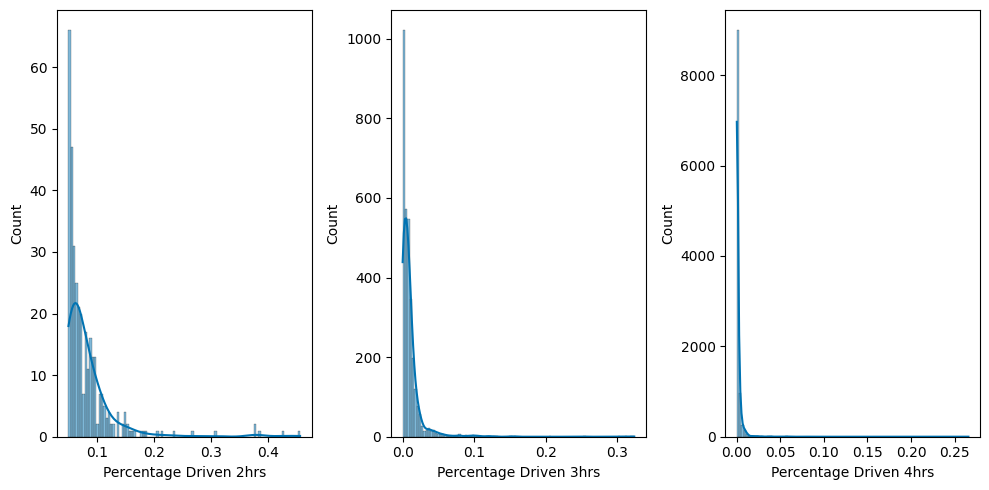

In [60]:
# Subset of data
fig, ax = plt.subplots(1,3,figsize=(10, 5))

sns.histplot(df['Pct.drive.2hrs'][df['Pct.drive.2hrs']>0.05], ax=ax[0], bins=100, kde=True)
ax[0].set_xlabel("Percentage Driven 2hrs")
ax[0].set_ylabel("Count")

sns.histplot(df['Pct.drive.3hrs'][df['Pct.drive.2hrs']>0.02], ax=ax[1], bins=100, kde=True)
ax[1].set_xlabel("Percentage Driven 3hrs")
ax[1].set_ylabel("Count")

sns.histplot(df['Pct.drive.4hrs'][df['Pct.drive.2hrs']>0.01], ax=ax[2], bins=100, kde=True)
ax[2].set_xlabel("Percentage Driven 4hrs")
ax[2].set_ylabel("Count")


fig.tight_layout()
plt.show()

In [61]:
df[["Pct.drive.2hrs", "Pct.drive.3hrs", "Pct.drive.4hrs"]].corr().style.background_gradient(cmap='coolwarm', axis=None)

In [62]:
sum(df["Pct.drive.2hrs"]==0)/df.shape[0]

0.28969

In [63]:
sum(df["Pct.drive.3hrs"]==0)/df.shape[0]

0.63151

In [64]:
sum(df["Pct.drive.4hrs"]==0)/df.shape[0]

0.85871

- Pct.drive.xxxxx: Percentage vehicle driven during wkday/wkend.

These are compositional, i.e. Pct.drive.wkend + Pct.drive.wkday = 1

In [65]:
df[['Pct.drive.wkday','Pct.drive.wkend']].describe()

Pct.drive.wkday  Pct.drive.wkend
count       100000.000       100000.000
mean             0.750            0.250
std              0.083            0.083
min              0.000            0.000
25%              0.710            0.205
50%              0.752            0.248
75%              0.795            0.290
max              1.000            1.000

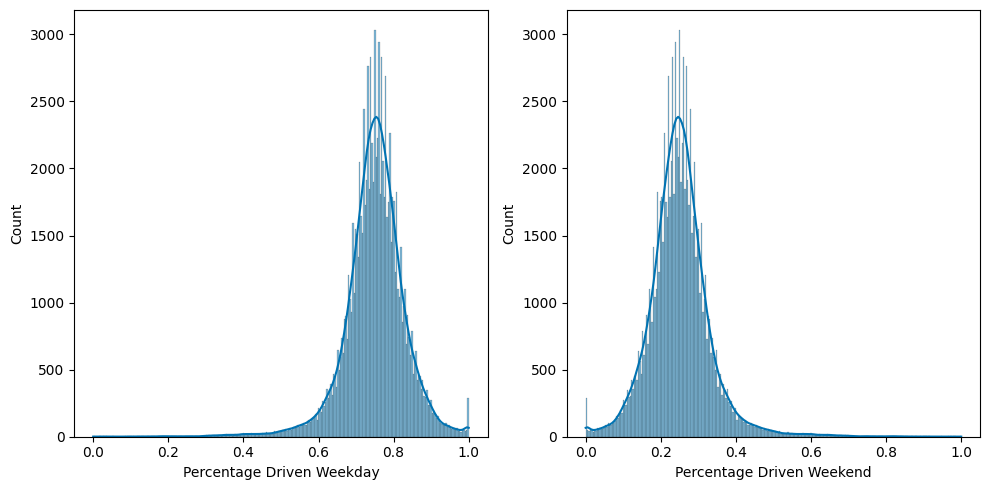

In [66]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.histplot(ax=ax[0], data=df, x='Pct.drive.wkday', kde=True)
ax[0].set_xlabel("Percentage Driven Weekday")
ax[0].set_ylabel("Count")

sns.histplot(ax=ax[1], data=df, x='Pct.drive.wkend', kde=True)
ax[1].set_xlabel("Percentage Driven Weekend")
ax[1].set_ylabel("Count")


fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/percentage_driven_week.png")

- Pct.drive.rush xx: Percent of driving during xx rush hours: am/pm.

In [67]:
df[['Pct.drive.rush am','Pct.drive.rush pm']].describe()

Pct.drive.rush am  Pct.drive.rush pm
count         100000.000         100000.000
mean               0.098              0.138
std                0.079              0.070
min                0.000              0.000
25%                0.037              0.090
50%                0.078              0.130
75%                0.141              0.174
max                0.988              0.993

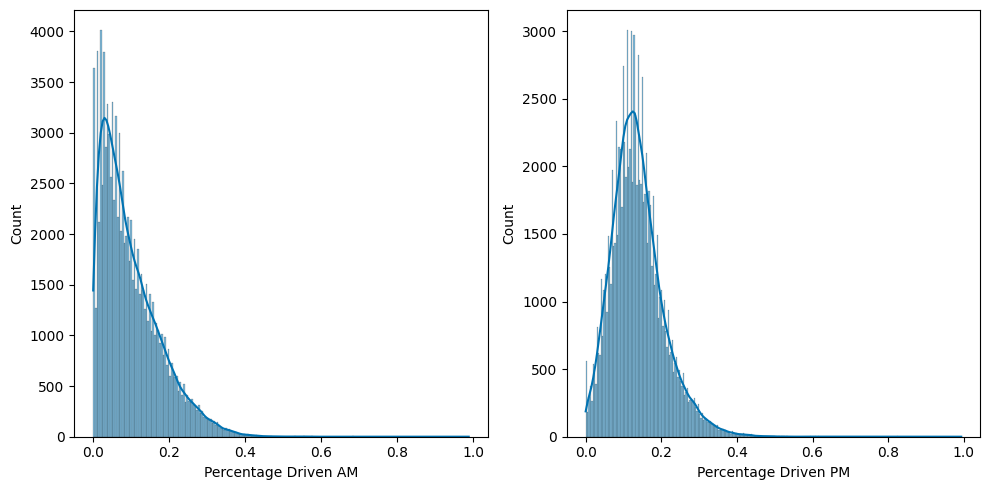

In [69]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.histplot(ax=ax[0], data=df, x='Pct.drive.rush am', kde=True)
ax[0].set_xlabel("Percentage Driven AM")
ax[0].set_ylabel("Count")

sns.histplot(ax=ax[1], data=df, x='Pct.drive.rush pm', kde=True)
ax[1].set_xlabel("Percentage Driven PM")
ax[1].set_ylabel("Count")


fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/percentage_driven_ampm.png")

In [70]:
df['Pct.drive.rush'] = df['Pct.drive.rush am'] + df['Pct.drive.rush pm']

In [71]:
# Combining this variable
df['Pct.drive.rush'].describe()

count   100000.000
mean         0.235
std          0.122
min          0.000
25%          0.151
50%          0.210
75%          0.296
max          1.000
Name: Pct.drive.rush, dtype: float64

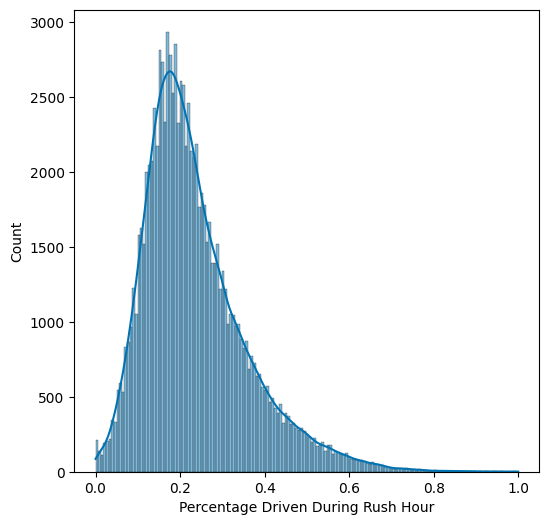

In [72]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(df['Pct.drive.rush'], ax=ax, kde=True)
ax.set_xlabel("Percentage Driven During Rush Hour")
#plt.show()
plt.savefig("../eda_figures/percentage_driven_rush.png")

In [73]:
df[["Pct.drive.rush am", "Pct.drive.rush pm", "Pct.drive.rush"]].corr().style.background_gradient(cmap='coolwarm', axis=None)

- Avgdays.week: Mean number of days used per week.

In [74]:
df['Avgdays.week'].describe()

count   100000.000
mean         5.533
std          1.248
min          0.201
25%          4.912
50%          5.890
75%          6.487
max          7.000
Name: Avgdays.week, dtype: float64

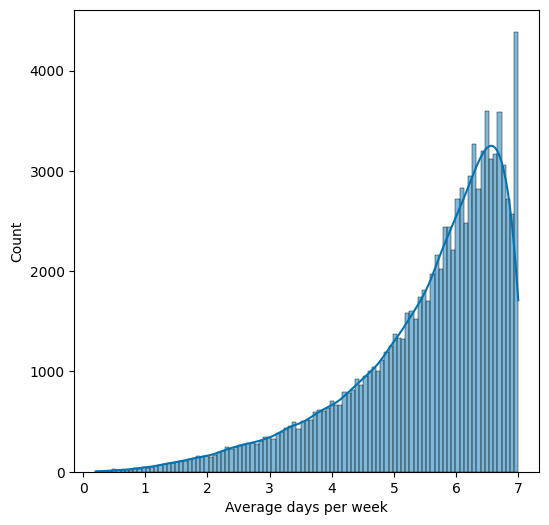

In [75]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(df['Avgdays.week'], ax=ax, kde=True)
ax.set_xlabel("Average days per week")
#plt.show()
plt.savefig("../eda_figures/avgdays_week.png")

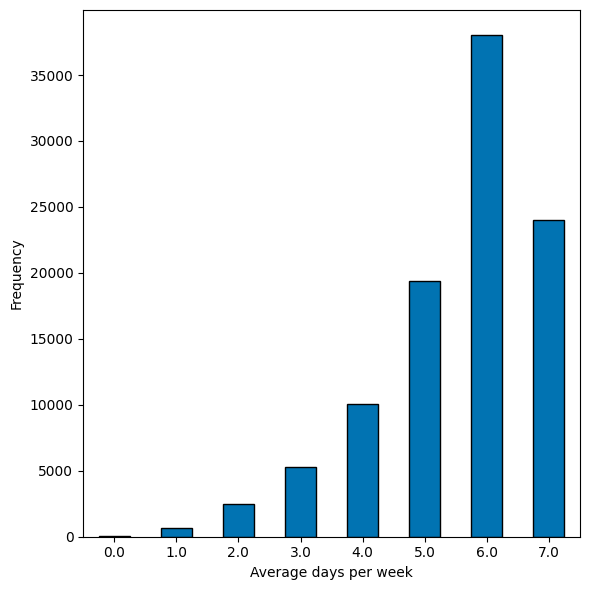

In [76]:
fig, ax = plt.subplots(figsize=(6, 6))
round(df['Avgdays.week']).value_counts().sort_index().plot(ax = ax, kind = 'bar', xlabel="Average days per week", ylabel = 'Frequency', rot=0, edgecolor='black')
fig.tight_layout()
plt.show()

- Accel.xxmiles: Number of sudden acceleration 06/08/09/11/12/14 mph/s per 1000 miles.

In [77]:
df[['Accel.06miles','Accel.08miles','Accel.09miles','Accel.11miles','Accel.12miles','Accel.14miles']].describe()

Accel.06miles  Accel.08miles  Accel.09miles  Accel.11miles  \
count     100000.000     100000.000     100000.000     100000.000   
mean          43.097          4.532          1.754          0.929   
std           62.105         19.531         14.560         11.936   
min            0.000          0.000          0.000          0.000   
25%            9.000          0.000          0.000          0.000   
50%           24.000          1.000          0.000          0.000   
75%           52.000          3.000          1.000          0.000   
max          621.000        621.000        621.000        621.000   

       Accel.12miles  Accel.14miles  
count     100000.000     100000.000  
mean           0.525          0.357  
std            9.699          8.434  
min            0.000          0.000  
25%            0.000          0.000  
50%            0.000          0.000  
75%            0.000          0.000  
max          621.000        621.000

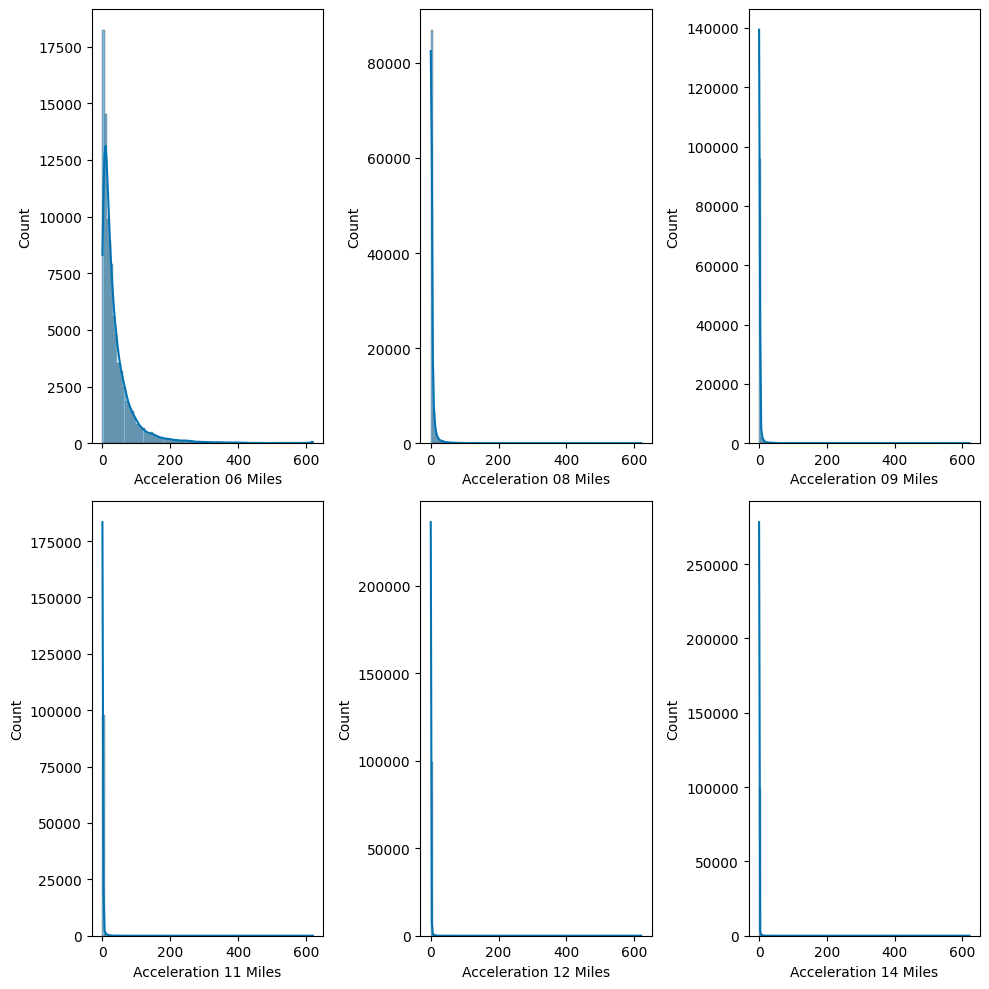

In [78]:
fig, ax = plt.subplots(2,3,figsize=(10, 10))
sns.histplot(df['Accel.06miles'], ax=ax[0,0], bins=100, kde=True)
ax[0,0].set_xlabel("Acceleration 06 Miles")
ax[0,0].set_ylabel("Count")

sns.histplot(df['Accel.08miles'], ax=ax[0,1], bins=100, kde=True)
ax[0,1].set_xlabel("Acceleration 08 Miles")
ax[0,1].set_ylabel("Count")

sns.histplot(df['Accel.09miles'], ax=ax[0,2], bins=100, kde=True)
ax[0,2].set_xlabel("Acceleration 09 Miles")
ax[0,2].set_ylabel("Count")

sns.histplot(df['Accel.11miles'], ax=ax[1,0], bins=100, kde=True)
ax[1,0].set_xlabel("Acceleration 11 Miles")
ax[1,0].set_ylabel("Count")

sns.histplot(df['Accel.12miles'], ax=ax[1,1], bins=100, kde=True)
ax[1,1].set_xlabel("Acceleration 12 Miles")
ax[1,1].set_ylabel("Count")

sns.histplot(df['Accel.14miles'], ax=ax[1,2], bins=100, kde=True)
ax[1,2].set_xlabel("Acceleration 14 Miles")
ax[1,2].set_ylabel("Count")


fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/acceleration.png")

In [79]:
print("Percentage of Number of sudden accelerations 06 mph/s per 1000 miles greater than 400: "+str(100*sum(df['Accel.06miles']>=400)/len(df))+"%")
print("Percentage of Number of sudden accelerations 08 mph/s per 1000 miles greater than 100: "+str(100*sum(df['Accel.08miles']>=100)/len(df))+"%")
print("Percentage of Number of sudden accelerations 09 mph/s per 1000 miles greater than 50: "+str(100*sum(df['Accel.09miles']>=50)/len(df))+"%")
print("Percentage of Number of sudden accelerations 11 mph/s per 1000 miles greater than 25: "+str(100*sum(df['Accel.11miles']>=25)/len(df))+"%")
print("Percentage of Number of sudden accelerations 12 mph/s per 1000 miles greater than 15: "+str(100*sum(df['Accel.12miles']>=15)/len(df))+"%")
print("Percentage of Number of sudden accelerations 14 mph/s per 1000 miles greater than 10: "+str(100*sum(df['Accel.14miles']>=10)/len(df))+"%")

Percentage of Number of sudden accelerations 06 mph/s per 1000 miles greater than 400: 0.551%
Percentage of Number of sudden accelerations 08 mph/s per 1000 miles greater than 100: 0.493%
Percentage of Number of sudden accelerations 09 mph/s per 1000 miles greater than 50: 0.373%
Percentage of Number of sudden accelerations 11 mph/s per 1000 miles greater than 25: 0.339%
Percentage of Number of sudden accelerations 12 mph/s per 1000 miles greater than 15: 0.293%
Percentage of Number of sudden accelerations 14 mph/s per 1000 miles greater than 10: 0.386%


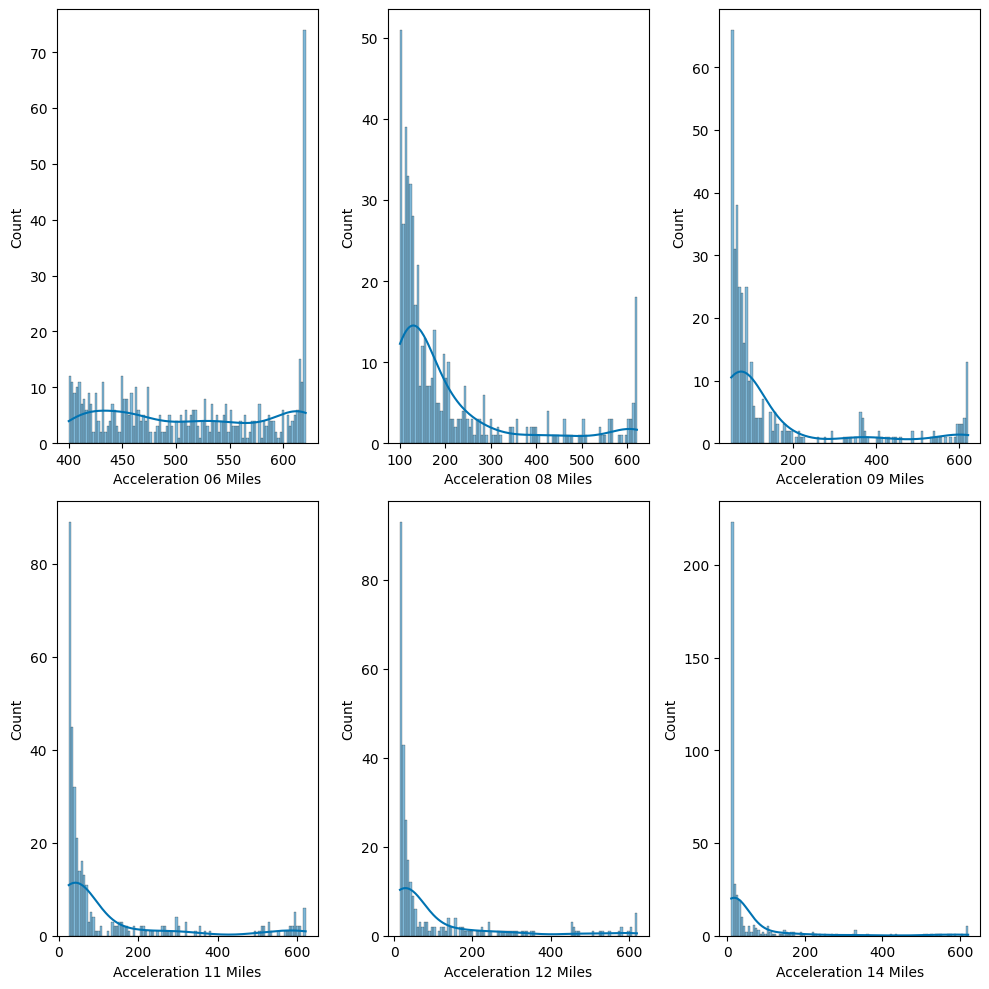

In [80]:
# Subset of data
fig, ax = plt.subplots(2,3,figsize=(10, 10))
sns.histplot(df['Accel.06miles'][df['Accel.06miles']>=400], ax=ax[0,0], bins=100, kde=True)
ax[0,0].set_xlabel("Acceleration 06 Miles")
ax[0,0].set_ylabel("Count")

sns.histplot(df['Accel.08miles'][df['Accel.08miles']>=100], ax=ax[0,1], bins=100, kde=True)
ax[0,1].set_xlabel("Acceleration 08 Miles")
ax[0,1].set_ylabel("Count")

sns.histplot(df['Accel.09miles'][df['Accel.09miles']>=50], ax=ax[0,2], bins=100, kde=True)
ax[0,2].set_xlabel("Acceleration 09 Miles")
ax[0,2].set_ylabel("Count")

sns.histplot(df['Accel.11miles'][df['Accel.11miles']>=25], ax=ax[1,0], bins=100, kde=True)
ax[1,0].set_xlabel("Acceleration 11 Miles")
ax[1,0].set_ylabel("Count")

sns.histplot(df['Accel.12miles'][df['Accel.12miles']>=15], ax=ax[1,1], bins=100, kde=True)
ax[1,1].set_xlabel("Acceleration 12 Miles")
ax[1,1].set_ylabel("Count")

sns.histplot(df['Accel.14miles'][df['Accel.14miles']>=10], ax=ax[1,2], bins=100, kde=True)
ax[1,2].set_xlabel("Acceleration 14 Miles")
ax[1,2].set_ylabel("Count")

fig.tight_layout()
#plt.show()

In [81]:
df[['Accel.06miles','Accel.08miles','Accel.09miles','Accel.11miles','Accel.12miles','Accel.14miles']].corr().style.background_gradient(cmap='coolwarm', axis=None)

- Brake.xxmiles: Number of sudden brakes 06/08/09/11/12/14 mph/s per 1000 miles.

In [82]:
df[['Brake.06miles','Brake.08miles','Brake.09miles','Brake.11miles','Brake.12miles','Brake.14miles']].describe()

Brake.06miles  Brake.08miles  Brake.09miles  Brake.11miles  \
count     100000.000     100000.000     100000.000     100000.000   
mean          83.653          9.594          3.103          1.349   
std           80.229         18.139         12.701         10.591   
min            0.000          0.000          0.000          0.000   
25%           33.000          3.000          1.000          0.000   
50%           60.000          6.000          2.000          1.000   
75%          107.000         11.000          3.000          1.000   
max          621.000        621.000        621.000        621.000   

       Brake.12miles  Brake.14miles  
count     100000.000     100000.000  
mean           0.590          0.355  
std            9.125          8.234  
min            0.000          0.000  
25%            0.000          0.000  
50%            0.000          0.000  
75%            0.000          0.000  
max          621.000        621.000

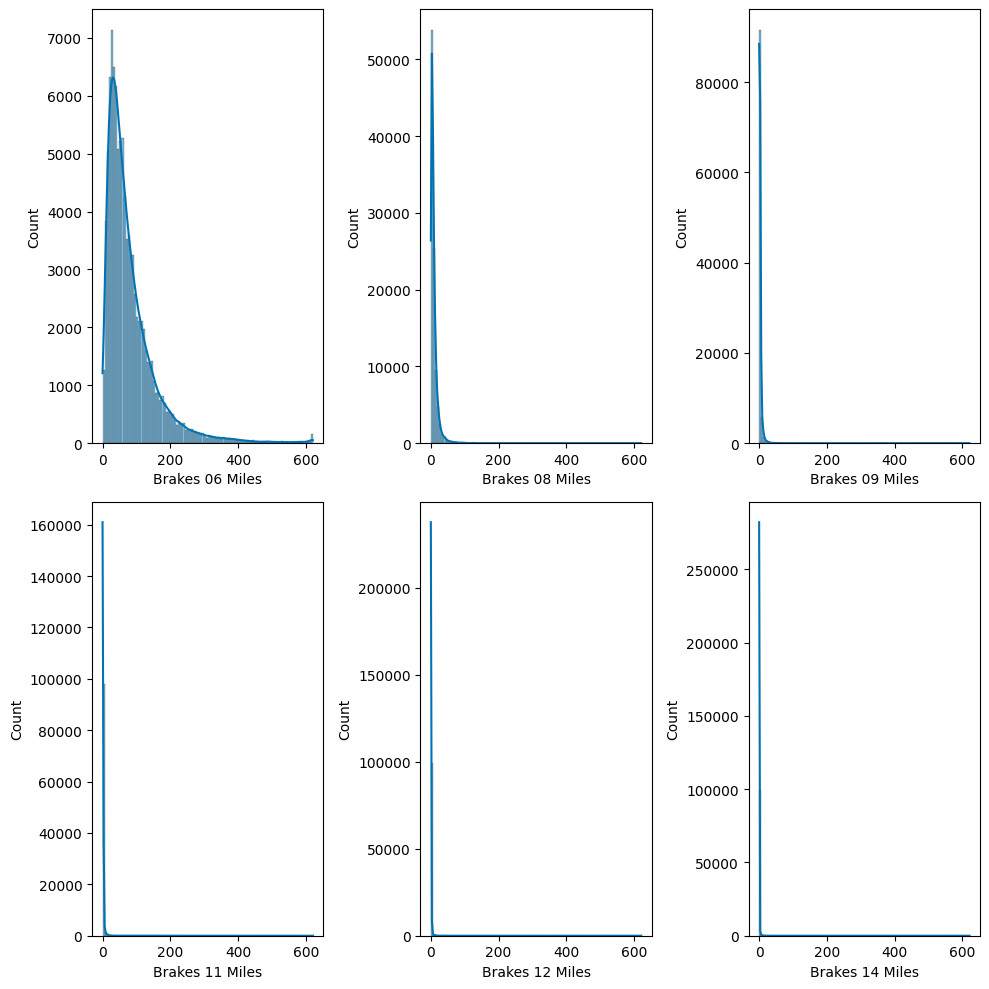

In [83]:
fig, ax = plt.subplots(2,3,figsize=(10, 10))
sns.histplot(df['Brake.06miles'], ax=ax[0,0], bins=100, kde=True)
ax[0,0].set_xlabel("Brakes 06 Miles")
ax[0,0].set_ylabel("Count")


sns.histplot(df['Brake.08miles'], ax=ax[0,1], bins=100, kde=True)
ax[0,1].set_xlabel("Brakes 08 Miles")
ax[0,1].set_ylabel("Count")

sns.histplot(df['Brake.09miles'], ax=ax[0,2], bins=100, kde=True)
ax[0,2].set_xlabel("Brakes 09 Miles")
ax[0,2].set_ylabel("Count")

sns.histplot(df['Brake.11miles'], ax=ax[1,0], bins=100, kde=True)
ax[1,0].set_xlabel("Brakes 11 Miles")
ax[1,0].set_ylabel("Count")


sns.histplot(df['Brake.12miles'], ax=ax[1,1], bins=100, kde=True)
ax[1,1].set_xlabel("Brakes 12 Miles")
ax[1,1].set_ylabel("Count")

sns.histplot(df['Brake.14miles'], ax=ax[1,2], bins=100, kde=True)
ax[1,2].set_xlabel("Brakes 14 Miles")
ax[1,2].set_ylabel("Count")


fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/braking.png")

In [84]:
print("Percentage of Number of sudden brakes 06 mph/s per 1000 miles greater than 500: "+str(100*sum(df['Brake.06miles']>=500)/len(df))+"%")
print("Percentage of Number of sudden brakes 08 mph/s per 1000 miles greater than 100: "+str(100*sum(df['Brake.08miles']>=100)/len(df))+"%")
print("Percentage of Number of sudden brakes 09 mph/s per 1000 miles greater than 50: "+str(100*sum(df['Brake.09miles']>=50)/len(df))+"%")
print("Percentage of Number of sudden brakes 11 mph/s per 1000 miles greater than 25: "+str(100*sum(df['Brake.11miles']>=25)/len(df))+"%")
print("Percentage of Number of sudden brakes 12 mph/s per 1000 miles greater than 15: "+str(100*sum(df['Brake.12miles']>=15)/len(df))+"%")
print("Percentage of Number of sudden brakes 14 mph/s per 1000 miles greater than 10: "+str(100*sum(df['Brake.14miles']>=10)/len(df))+"%")

Percentage of Number of sudden brakes 06 mph/s per 1000 miles greater than 500: 0.557%
Percentage of Number of sudden brakes 08 mph/s per 1000 miles greater than 100: 0.333%
Percentage of Number of sudden brakes 09 mph/s per 1000 miles greater than 50: 0.23%
Percentage of Number of sudden brakes 11 mph/s per 1000 miles greater than 25: 0.238%
Percentage of Number of sudden brakes 12 mph/s per 1000 miles greater than 15: 0.258%
Percentage of Number of sudden brakes 14 mph/s per 1000 miles greater than 10: 0.372%


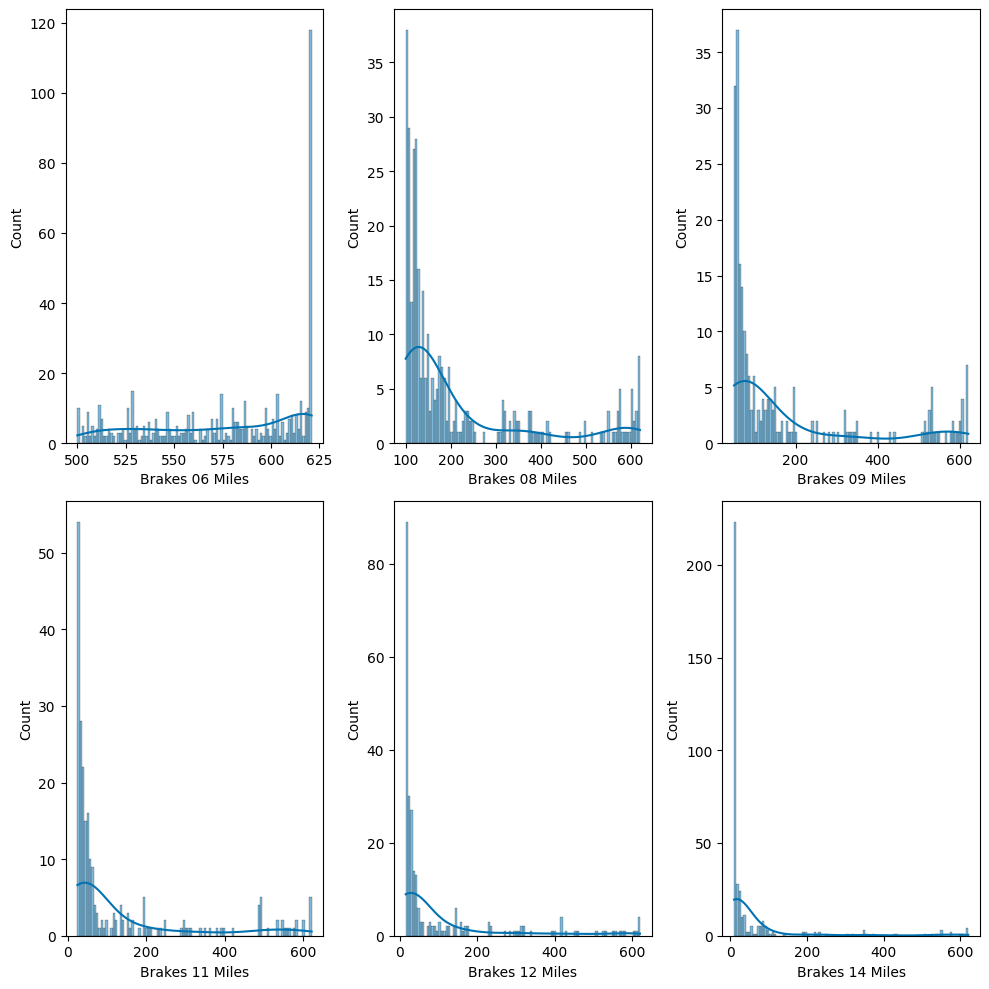

In [85]:
# Subset of data
fig, ax = plt.subplots(2,3,figsize=(10, 10))
sns.histplot(df['Brake.06miles'][df['Brake.06miles']>=500], ax=ax[0,0], bins=100, kde=True)
ax[0,0].set_xlabel("Brakes 06 Miles")
ax[0,0].set_ylabel("Count")


sns.histplot(df['Brake.08miles'][df['Brake.08miles']>=100], ax=ax[0,1], bins=100, kde=True)
ax[0,1].set_xlabel("Brakes 08 Miles")
ax[0,1].set_ylabel("Count")

sns.histplot(df['Brake.09miles'][df['Brake.09miles']>=50], ax=ax[0,2], bins=100, kde=True)
ax[0,2].set_xlabel("Brakes 09 Miles")
ax[0,2].set_ylabel("Count")

sns.histplot(df['Brake.11miles'][df['Brake.11miles']>=25], ax=ax[1,0], bins=100, kde=True)
ax[1,0].set_xlabel("Brakes 11 Miles")
ax[1,0].set_ylabel("Count")

sns.histplot(df['Brake.12miles'][df['Brake.12miles']>=15], ax=ax[1,1], bins=100, kde=True)
ax[1,1].set_xlabel("Brakes 12 Miles")
ax[1,1].set_ylabel("Count")

sns.histplot(df['Brake.14miles'][df['Brake.14miles']>=10], ax=ax[1,2], bins=100, kde=True)
ax[1,2].set_xlabel("Brakes 14 Miles")
ax[1,2].set_ylabel("Count")

fig.tight_layout()
plt.show()

In [86]:
df[['Brake.06miles','Brake.08miles','Brake.09miles','Brake.11miles','Brake.12miles','Brake.14miles']].corr().style.background_gradient(cmap='coolwarm', axis=None)

- Left.turn.intensityxx: Number of left turns per 1000 miles with intensity 08/09/10/11/12.

In [87]:
df[['Left.turn.intensity08','Left.turn.intensity09','Left.turn.intensity10','Left.turn.intensity11','Left.turn.intensity12']].describe()

Left.turn.intensity08  Left.turn.intensity09  Left.turn.intensity10  \
count             100000.000             100000.000             100000.000   
mean                 915.676                718.054                551.574   
std                16330.899              15666.069              14687.930   
min                    0.000                  0.000                  0.000   
25%                    7.000                  2.000                  0.000   
50%                   66.000                 22.000                  3.000   
75%                  361.000                146.000                 30.000   
max               794740.000             794676.000             794380.000   

       Left.turn.intensity11  Left.turn.intensity12  
count             100000.000             100000.000  
mean                 487.341                447.758  
std                14198.331              13719.790  
min                    0.000                  0.000  
25%                    0.000                  0.000  
50%                    1.000                  0.000  
75%                    9.000                  2.000  
max               793926.000             793170.000

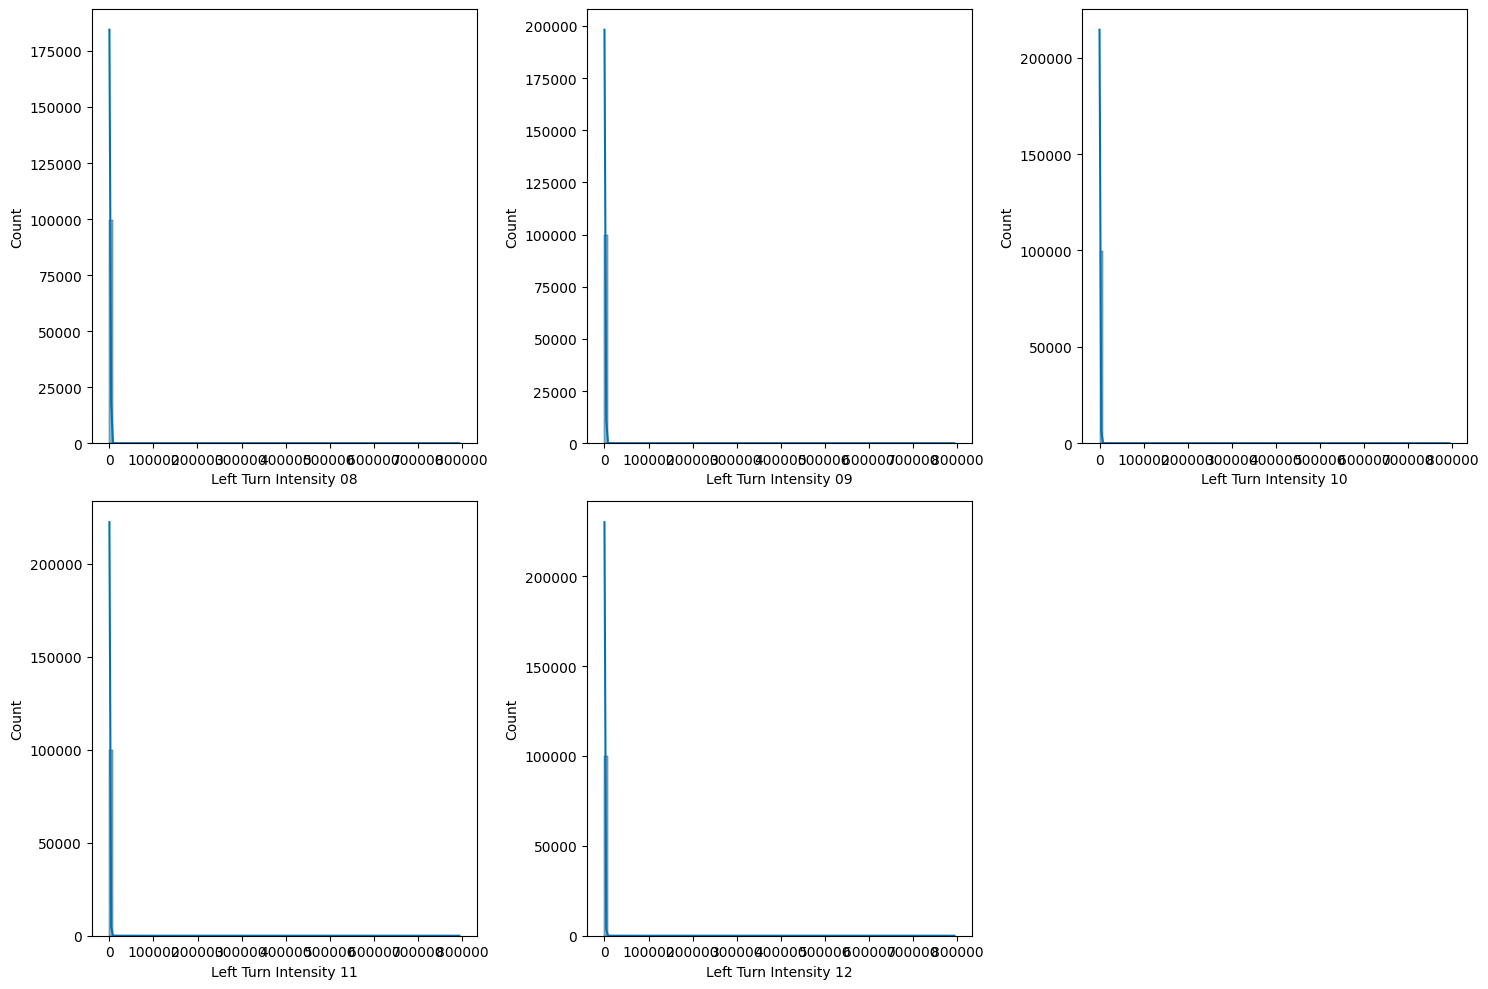

In [88]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

sns.histplot(df['Left.turn.intensity08'], ax=axs[0,0], bins=100, kde=True)
axs[0,0].set_xlabel("Left Turn Intensity 08")
axs[0,0].set_ylabel("Count")

sns.histplot(df['Left.turn.intensity09'], ax=axs[0,1], bins=100, kde=True)
axs[0,1].set_xlabel("Left Turn Intensity 09")
axs[0,1].set_ylabel("Count")

sns.histplot(df['Left.turn.intensity10'], ax=axs[0,2], bins=100, kde=True)
axs[0,2].set_xlabel("Left Turn Intensity 10")
axs[0,2].set_ylabel("Count")

sns.histplot(df['Left.turn.intensity11'], ax=axs[1,0], bins=100, kde=True)
axs[1,0].set_xlabel("Left Turn Intensity 11")
axs[1,0].set_ylabel("Count")

sns.histplot(df['Left.turn.intensity12'], ax=axs[1,1], bins=100, kde=True)
axs[1,1].set_xlabel("Left Turn Intensity 12")
axs[1,1].set_ylabel("Count")

fig.delaxes(ax=axs[1,2])

fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/left_turn.png")

In [89]:
print("Percentage of dataset with number of left turns per 1000 miles with intensity 08 greater than 10,000: "+str(100*sum(df['Left.turn.intensity08']>=10000)/len(df))+"%")
print("Percentage of dataset with number of left turns per 1000 miles with intensity 09 greater than 10,000: "+str(100*sum(df['Left.turn.intensity09']>=10000)/len(df))+"%")
print("Percentage of dataset with number of left turns per 1000 miles with intensity 10 greater than 10,000: "+str(100*sum(df['Left.turn.intensity10']>=10000)/len(df))+"%")
print("Percentage of dataset with number of left turns per 1000 miles with intensity 11 greater than 10,000: "+str(100*sum(df['Left.turn.intensity11']>=10000)/len(df))+"%")
print("Percentage of dataset with number of left turns per 1000 miles with intensity 12 greater than 10,000: "+str(100*sum(df['Left.turn.intensity12']>=10000)/len(df))+"%")

Percentage of dataset with number of left turns per 1000 miles with intensity 08 greater than 10,000: 0.234%
Percentage of dataset with number of left turns per 1000 miles with intensity 09 greater than 10,000: 0.208%
Percentage of dataset with number of left turns per 1000 miles with intensity 10 greater than 10,000: 0.179%
Percentage of dataset with number of left turns per 1000 miles with intensity 11 greater than 10,000: 0.175%
Percentage of dataset with number of left turns per 1000 miles with intensity 12 greater than 10,000: 0.161%


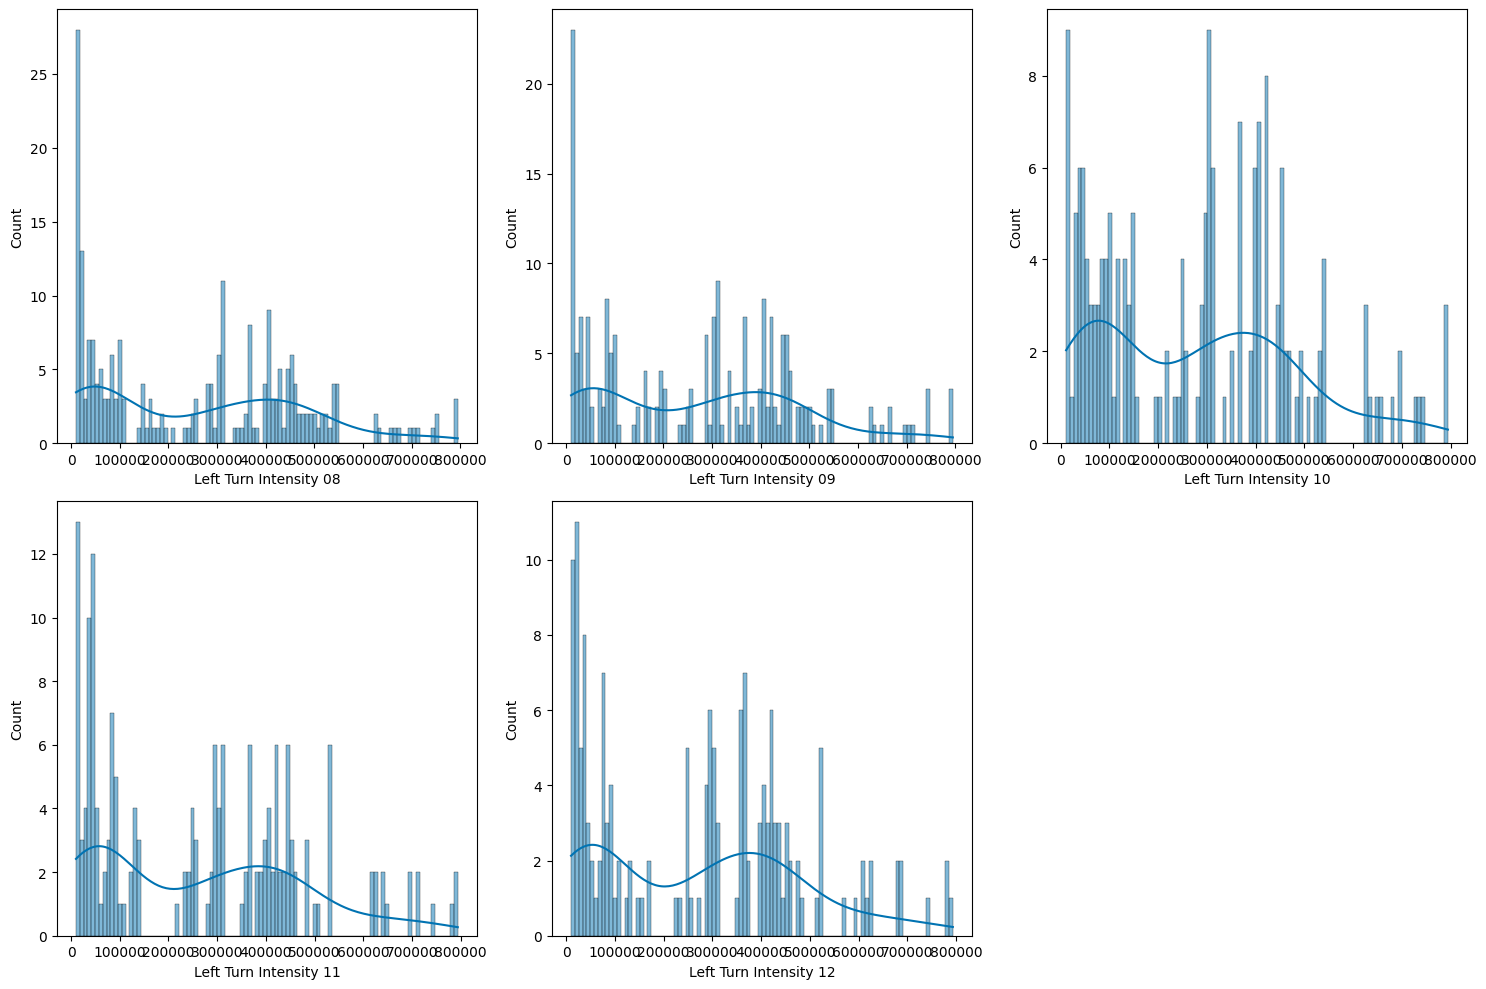

In [90]:
# Subset of data
fig, axs = plt.subplots(2,3,figsize=(15, 10))
sns.histplot(df['Left.turn.intensity08'][df['Left.turn.intensity08']>=10000], ax=axs[0,0], bins=100, kde=True)
axs[0,0].set_xlabel("Left Turn Intensity 08")
axs[0,0].set_ylabel("Count")

sns.histplot(df['Left.turn.intensity09'][df['Left.turn.intensity09']>=10000], ax=axs[0,1], bins=100, kde=True)
axs[0,1].set_xlabel("Left Turn Intensity 09")
axs[0,1].set_ylabel("Count")

sns.histplot(df['Left.turn.intensity10'][df['Left.turn.intensity10']>=10000], ax=axs[0,2], bins=100, kde=True)
axs[0,2].set_xlabel("Left Turn Intensity 10")
axs[0,2].set_ylabel("Count")


sns.histplot(df['Left.turn.intensity11'][df['Left.turn.intensity11']>=10000], ax=axs[1,0], bins=100, kde=True)
axs[1,0].set_xlabel("Left Turn Intensity 11")
axs[1,0].set_ylabel("Count")

sns.histplot(df['Left.turn.intensity12'][df['Left.turn.intensity12']>=10000], ax=axs[1,1], bins=100, kde=True)
axs[1,1].set_xlabel("Left Turn Intensity 12")
axs[1,1].set_ylabel("Count")

fig.delaxes(ax=axs[1,2])

fig.tight_layout()
plt.show()

In [91]:
df[['Left.turn.intensity08','Left.turn.intensity09','Left.turn.intensity10','Left.turn.intensity11','Left.turn.intensity12']].corr().style.background_gradient(cmap='coolwarm', axis=None)

In [73]:
# Takes too long
#sns.pairplot(df.sample((1000))[['Left.turn.intensity08','Left.turn.intensity09','Left.turn.intensity10','Left.turn.intensity11','Left.turn.intensity12']])

- Right.turn.intensityxx: Number of right turns per 1000 miles with intensity 08/09/10/11/12.

In [92]:
df[['Right.turn.intensity08','Right.turn.intensity09','Right.turn.intensity10','Right.turn.intensity11','Right.turn.intensity12']].describe()

Right.turn.intensity08  Right.turn.intensity09  Right.turn.intensity10  \
count              100000.000              100000.000              100000.000   
mean                  843.462                 565.056                 326.655   
std                 11630.186               10657.403                9460.244   
min                     0.000                   0.000                   0.000   
25%                    11.000                   3.000                   0.000   
50%                   122.000                  43.000                   7.000   
75%                   680.000                 321.000                  81.000   
max                841210.000              841207.000              841200.000   

       Right.turn.intensity11  Right.turn.intensity12  
count              100000.000              100000.000  
mean                  246.713                 198.754  
std                  8977.570                8585.177  
min                     0.000                   0.000  
25%                     0.000                   0.000  
50%                     2.000                   0.000  
75%                    27.000                   9.000  
max                841176.000              841144.000

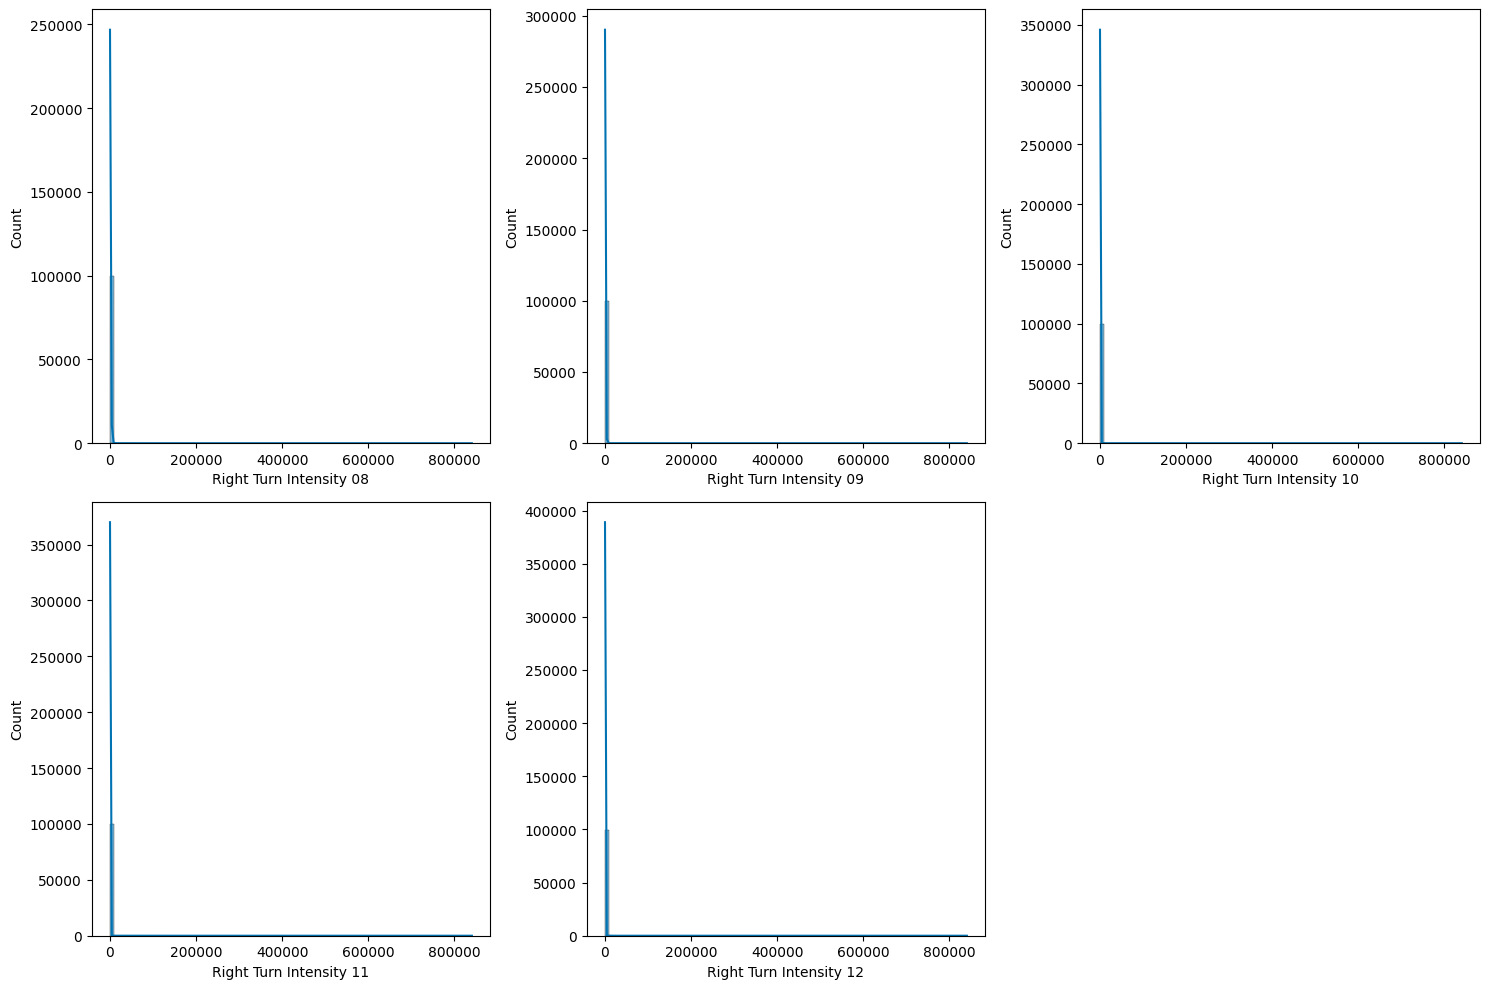

In [93]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

sns.histplot(df['Right.turn.intensity08'], ax=axs[0,0], bins=100, kde=True)
axs[0,0].set_xlabel("Right Turn Intensity 08")
axs[0,0].set_ylabel("Count")

sns.histplot(df['Right.turn.intensity09'], ax=axs[0,1], bins=100, kde=True)
axs[0,1].set_xlabel("Right Turn Intensity 09")
axs[0,1].set_ylabel("Count")

sns.histplot(df['Right.turn.intensity10'], ax=axs[0,2], bins=100, kde=True)
axs[0,2].set_xlabel("Right Turn Intensity 10")
axs[0,2].set_ylabel("Count")


sns.histplot(df['Right.turn.intensity11'], ax=axs[1,0], bins=100, kde=True)
axs[1,0].set_xlabel("Right Turn Intensity 11")
axs[1,0].set_ylabel("Count")

sns.histplot(df['Right.turn.intensity12'], ax=axs[1,1], bins=100, kde=True)
axs[1,1].set_xlabel("Right Turn Intensity 12")
axs[1,1].set_ylabel("Count")

fig.delaxes(ax=axs[1,2])

fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/right_turn.png")

In [94]:
print("Percentage of dataset with number of right turns per 1000 miles with intensity 08 greater than 10,000: "+str(100*sum(df['Right.turn.intensity08']>=10000)/len(df))+"%")
print("Percentage of dataset with number of right turns per 1000 miles with intensity 09 greater than 10,000: "+str(100*sum(df['Right.turn.intensity09']>=10000)/len(df))+"%")
print("Percentage of dataset with number of right turns per 1000 miles with intensity 10 greater than 10,000: "+str(100*sum(df['Right.turn.intensity10']>=10000)/len(df))+"%")
print("Percentage of dataset with number of right turns per 1000 miles with intensity 11 greater than 10,000: "+str(100*sum(df['Right.turn.intensity11']>=10000)/len(df))+"%")
print("Percentage of dataset with number of right turns per 1000 miles with intensity 12 greater than 10,000: "+str(100*sum(df['Right.turn.intensity12']>=10000)/len(df))+"%")

Percentage of dataset with number of right turns per 1000 miles with intensity 08 greater than 10,000: 0.216%
Percentage of dataset with number of right turns per 1000 miles with intensity 09 greater than 10,000: 0.163%
Percentage of dataset with number of right turns per 1000 miles with intensity 10 greater than 10,000: 0.118%
Percentage of dataset with number of right turns per 1000 miles with intensity 11 greater than 10,000: 0.111%
Percentage of dataset with number of right turns per 1000 miles with intensity 12 greater than 10,000: 0.093%


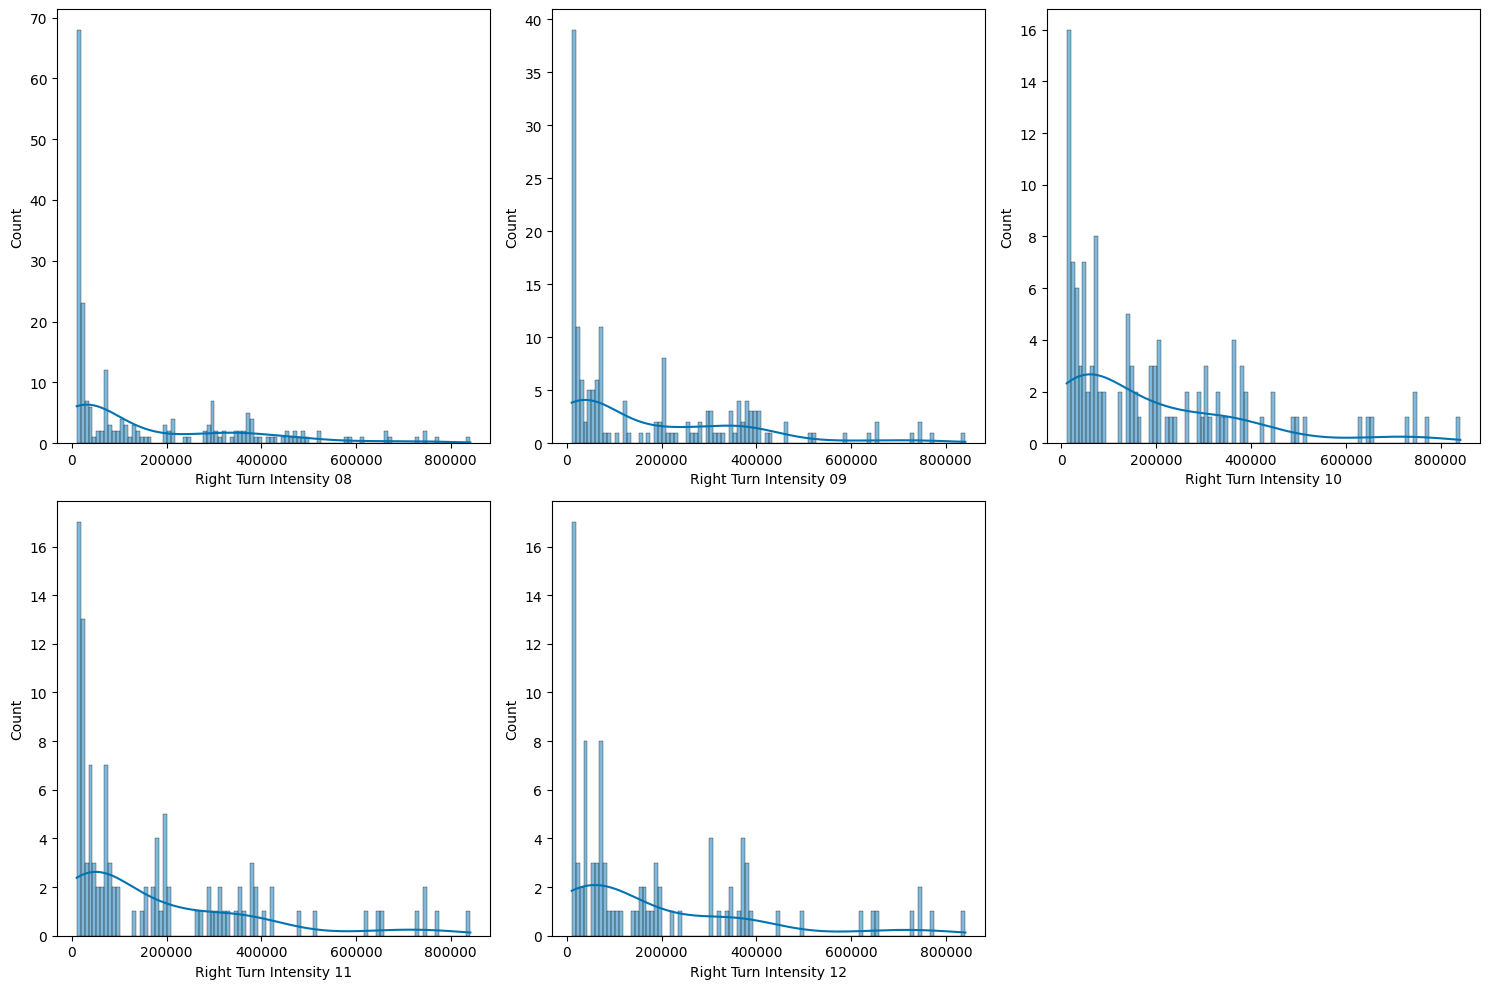

In [95]:
# Subset
fig, axs = plt.subplots(2,3,figsize=(15, 10))
sns.histplot(df['Right.turn.intensity08'][df['Right.turn.intensity08']>=10000], ax=axs[0,0], bins=100, kde=True)
axs[0,0].set_xlabel("Right Turn Intensity 08")
axs[0,0].set_ylabel("Count")

sns.histplot(df['Right.turn.intensity09'][df['Right.turn.intensity09']>=10000], ax=axs[0,1], bins=100, kde=True)
axs[0,1].set_xlabel("Right Turn Intensity 09")
axs[0,1].set_ylabel("Count")

sns.histplot(df['Right.turn.intensity10'][df['Right.turn.intensity10']>=10000], ax=axs[0,2], bins=100, kde=True)
axs[0,2].set_xlabel("Right Turn Intensity 10")
axs[0,2].set_ylabel("Count")


sns.histplot(df['Right.turn.intensity11'][df['Right.turn.intensity11']>=10000], ax=axs[1,0], bins=100, kde=True)
axs[1,0].set_xlabel("Right Turn Intensity 11")
axs[1,0].set_ylabel("Count")

sns.histplot(df['Right.turn.intensity12'][df['Right.turn.intensity12']>=10000], ax=axs[1,1], bins=100, kde=True)
axs[1,1].set_xlabel("Right Turn Intensity 12")
axs[1,1].set_ylabel("Count")

fig.delaxes(ax=axs[1,2])

fig.tight_layout()
plt.show()

In [96]:
df[['Right.turn.intensity08','Right.turn.intensity09','Right.turn.intensity10','Right.turn.intensity11','Right.turn.intensity12']].corr().style.background_gradient(cmap='coolwarm', axis=None)

- NB_Claim: Number of claims during observation

In [97]:
df['NB_Claim'].describe()

count   100000.000
mean         0.045
std          0.218
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          3.000
Name: NB_Claim, dtype: float64

In [98]:
df['NB_Claim'].value_counts()

NB_Claim
0    95728
1     4061
2      200
3       11
Name: count, dtype: int64

In [99]:
# Claims only
df['NB_Claim'][df['NB_Claim']!=0].describe()

count   4272.000
mean       1.052
std        0.233
min        1.000
25%        1.000
50%        1.000
75%        1.000
max        3.000
Name: NB_Claim, dtype: float64

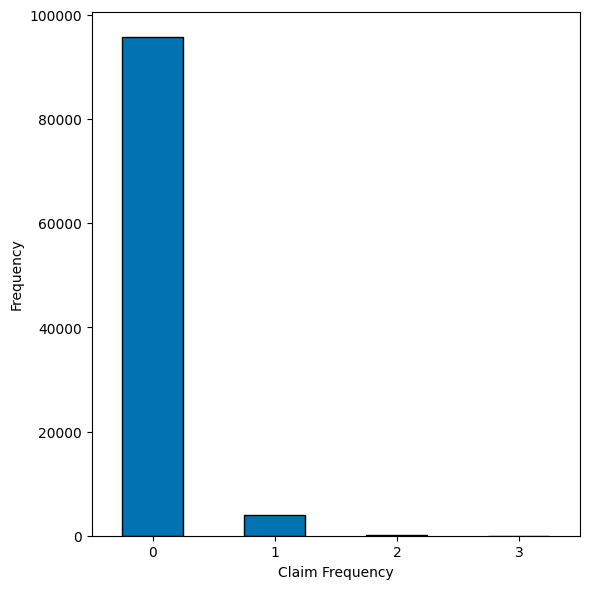

In [100]:
fig, ax = plt.subplots(figsize=(6, 6))
df['NB_Claim'].value_counts().plot(ax = ax, kind = 'bar', xlabel="Claim Frequency", ylabel = 'Frequency', rot=0, edgecolor='black')
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/nb_claim.png")

In [101]:
print(sum(df['NB_Claim']==0)/df.shape[0])
print(sum(df['NB_Claim']>=1)/df.shape[0])

0.95728
0.04272


- AMT_Claim: Aggregated amount of claims during observation

In [102]:
df['AMT_Claim'].describe()

count   100000.000
mean       137.602
std       1264.320
min          0.000
25%          0.000
50%          0.000
75%          0.000
max     104074.887
Name: AMT_Claim, dtype: float64

In [103]:
# Policies with a claim
df['AMT_Claim'][df['NB_Claim']!=0].describe()
# there are 408 claims with an amount of 0

count     4272.000
mean      3221.027
std       5243.326
min          0.000
25%        530.192
50%       1718.503
75%       3783.871
max     104074.887
Name: AMT_Claim, dtype: float64

In [104]:
# Claims with AMT_Claim>0
df['AMT_Claim'][df['AMT_Claim']!=0].describe()

count     3864.000
mean      3561.135
std       5402.283
min          0.770
25%        786.272
50%       1988.596
75%       4037.888
max     104074.887
Name: AMT_Claim, dtype: float64

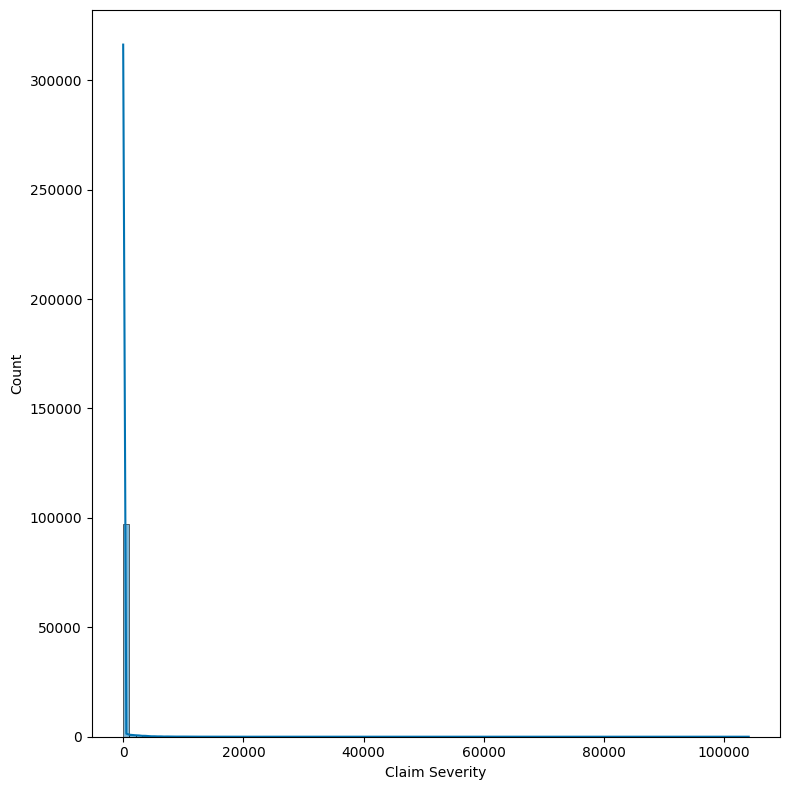

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(df['AMT_Claim'], ax=ax, bins=100, kde=True)
ax.set_xlabel("Claim Severity")
ax.set_ylabel("Count")
fig.tight_layout()
#plt.show()
plt.savefig("../eda_figures/amt_claim.png")

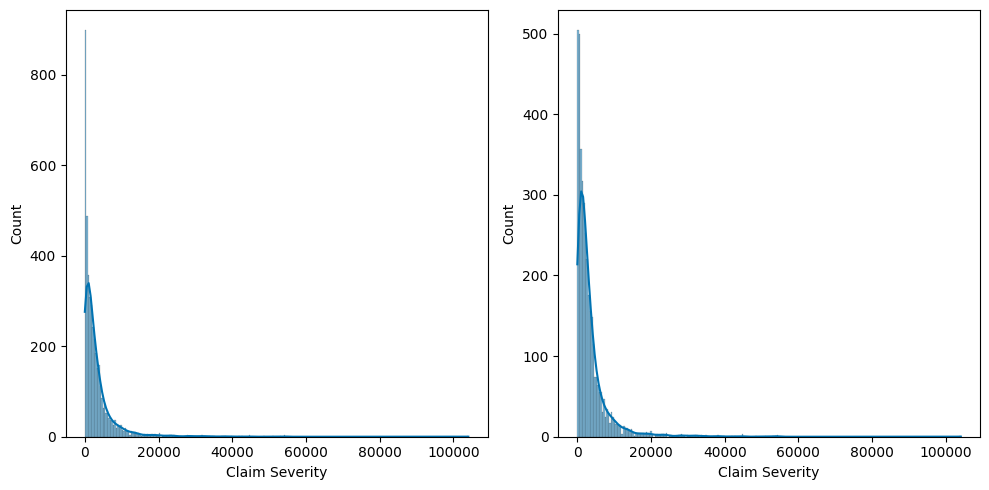

In [107]:

fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.histplot(df['AMT_Claim'][df['NB_Claim']!=0], ax=ax[0], kde=True)
ax[0].set_xlabel("Claim Severity")
ax[0].set_ylabel("Count")


sns.histplot(df['AMT_Claim'][df['AMT_Claim']!=0], ax=ax[1], kde=True)
ax[1].set_xlabel("Claim Severity")
ax[1].set_ylabel("Count")


fig.tight_layout()
plt.show()

## Correlation

In [108]:
df.select_dtypes(exclude=object).corr().style.background_gradient(cmap='coolwarm', axis=None)

In [109]:
df[["Annual.miles.drive", "Annual.pct.driven", "Total.miles.driven", "Avgdays.week"]].corr().style.background_gradient(cmap='coolwarm', axis=None)

In [110]:
df[[
    'Left.turn.intensity08','Left.turn.intensity09','Left.turn.intensity10','Left.turn.intensity11',
    'Left.turn.intensity12','Right.turn.intensity08','Right.turn.intensity09','Right.turn.intensity10',
    'Right.turn.intensity11','Right.turn.intensity12'
]].corr().style.background_gradient(cmap='coolwarm', axis=None)

In [111]:
df[[
    'Accel.06miles','Accel.08miles','Accel.09miles','Accel.11miles','Accel.12miles','Accel.14miles',
    'Brake.06miles','Brake.08miles','Brake.09miles','Brake.11miles','Brake.12miles','Brake.14miles'
]].corr().style.background_gradient(cmap='coolwarm', axis=None)

# Comparison

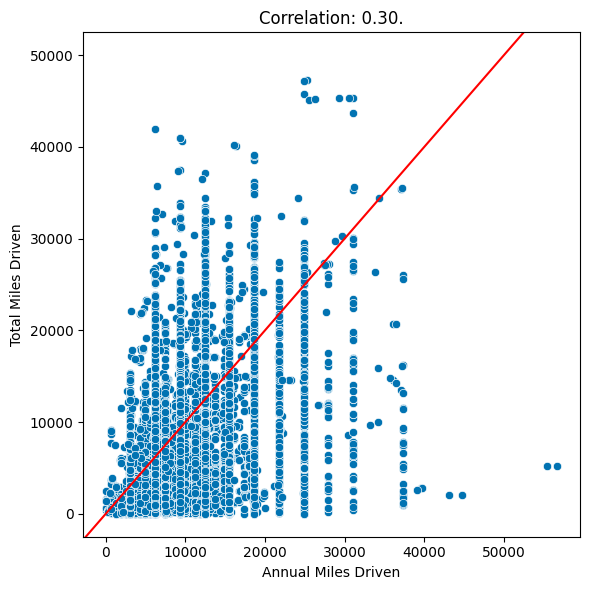

In [112]:
# Annual Miles vs Total Miles
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df, x='Annual.miles.drive', y='Total.miles.driven', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(df['Annual.miles.drive'], df['Total.miles.driven'])[0,1])
ax.axline([0, 0], [50000, 50000], color='red')
ax.set_xlabel("Annual Miles Driven")
ax.set_ylabel("Total Miles Driven")
fig.tight_layout()
plt.show()
# Annual miles expected to be driven declared by driver compared to Total distance driven in miles.


In [113]:
# rmse
np.mean(np.sqrt((df['Annual.miles.drive']-df['Total.miles.driven'])**2))

5446.356848733098

In [114]:
# average error
np.mean(df['Total.miles.driven']-df['Annual.miles.drive'])

-4290.547605283042

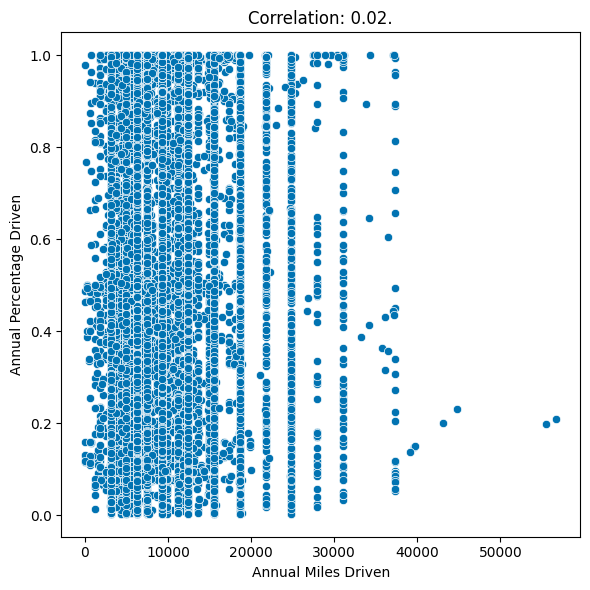

In [115]:
# Annual Miles vs Annual.pct.driven
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df, x='Annual.miles.drive', y='Annual.pct.driven', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(df['Annual.miles.drive'], df['Annual.pct.driven'])[0,1])
ax.set_xlabel("Annual Miles Driven")
ax.set_ylabel("Annual Percentage Driven")
fig.tight_layout()
plt.show()
# Annual miles expected to be driven declared by driver compared to Annualized percentage of time on the road.

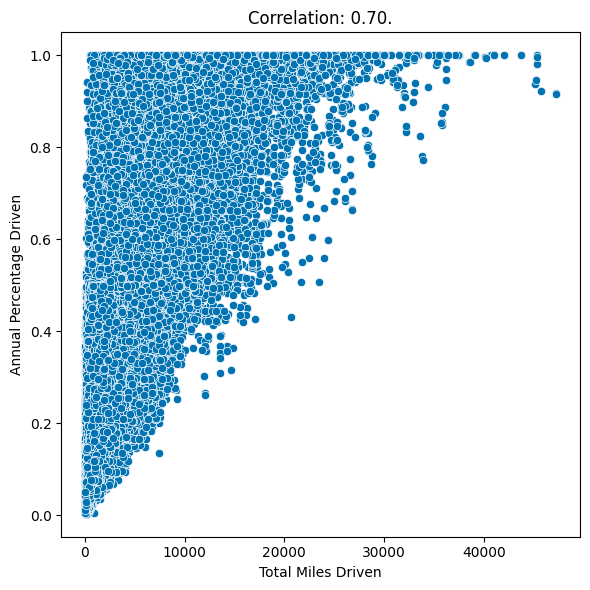

In [116]:
# Total Miles vs Annual.pct.driven
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df, x='Total.miles.driven', y='Annual.pct.driven', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(df['Total.miles.driven'], df['Annual.pct.driven'])[0,1])
ax.set_xlabel("Total Miles Driven")
ax.set_ylabel("Annual Percentage Driven")
fig.tight_layout()
plt.show()
# Total distance driven in miles compared to Annualized percentage of time on the road.



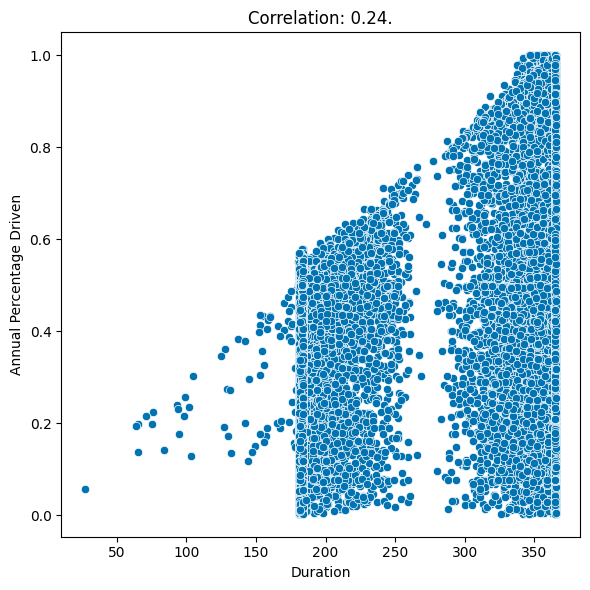

In [117]:
# Duration vs Annual.pct.driven
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df, x='Duration', y='Annual.pct.driven', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(df['Duration'], df['Annual.pct.driven'])[0,1])
ax.set_xlabel("Duration")
ax.set_ylabel("Annual Percentage Driven")
fig.tight_layout()
plt.show()
# Duration (the period that policyholder is insured in days) compared to Number of days they spent on the road.

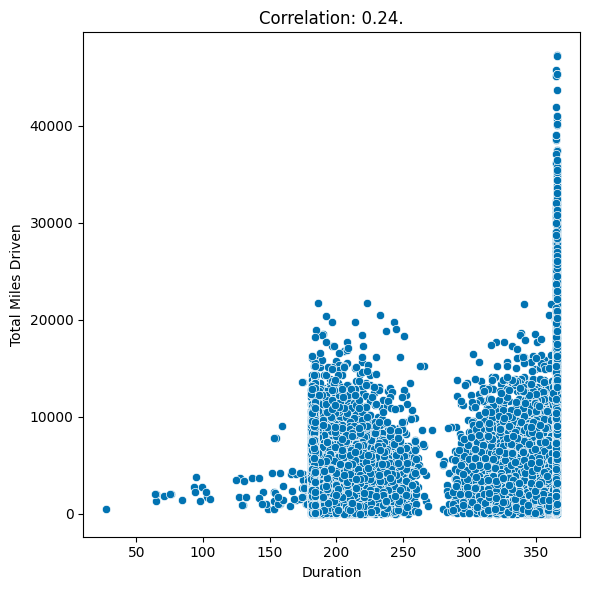

In [118]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df, x='Duration', y='Total.miles.driven', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(df['Duration'], df['Total.miles.driven'])[0,1])
ax.set_xlabel("Duration")
ax.set_ylabel("Total Miles Driven")
fig.tight_layout()
plt.show()

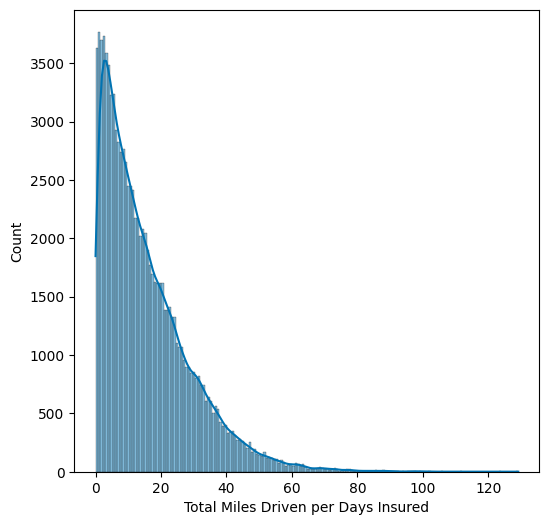

In [119]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(df['Total.miles.driven'] / df['Duration'], ax=ax, kde=True)
ax.set_xlabel("Total Miles Driven per Days Insured")
plt.show()

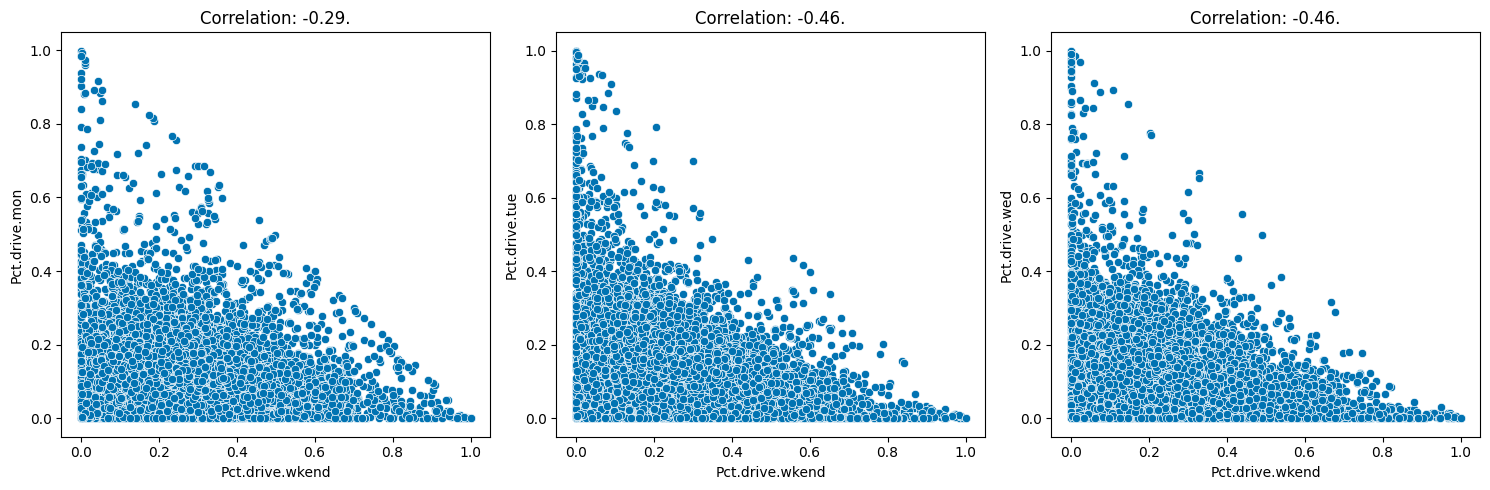

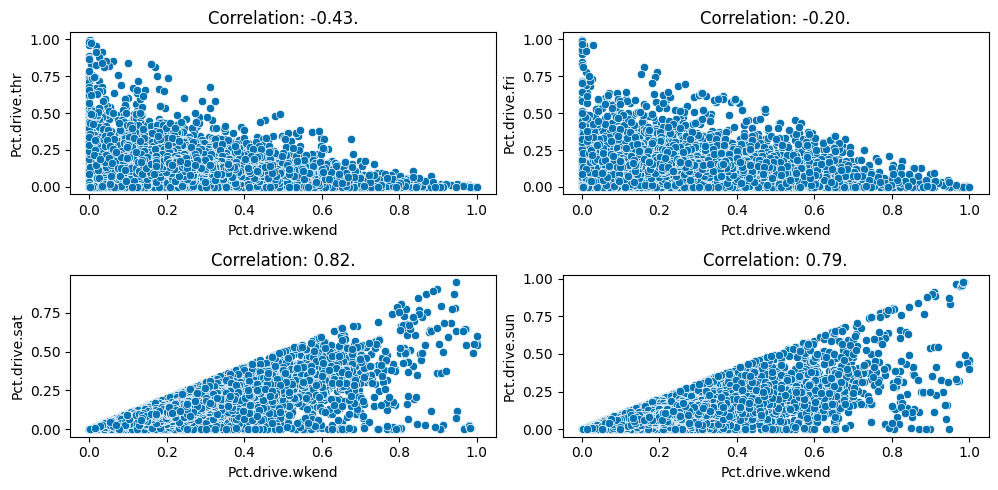

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df, x='Pct.drive.wkend', y='Pct.drive.mon', ax=ax[0])
ax[0].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkend'], df['Pct.drive.mon'])[0,1])
ax[0].set_xlabel("Pct.drive.wkend")
ax[0].set_ylabel("Pct.drive.mon")

sns.scatterplot(data=df, x='Pct.drive.wkend', y='Pct.drive.tue', ax=ax[1])
ax[1].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkend'], df['Pct.drive.tue'])[0,1])
ax[1].set_xlabel("Pct.drive.wkend")
ax[1].set_ylabel("Pct.drive.tue")

sns.scatterplot(data=df, x='Pct.drive.wkend', y='Pct.drive.wed', ax=ax[2])
ax[2].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkend'], df['Pct.drive.wed'])[0,1])
ax[2].set_xlabel("Pct.drive.wkend")
ax[2].set_ylabel("Pct.drive.wed")

fig1, ax1 = plt.subplots(2, 2, figsize=(10, 5))

sns.scatterplot(data=df, x='Pct.drive.wkend', y='Pct.drive.thr', ax=ax1[0,0])
ax1[0,0].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkend'], df['Pct.drive.thr'])[0,1])
ax1[0,0].set_xlabel("Pct.drive.wkend")
ax1[0,0].set_ylabel("Pct.drive.thr")

sns.scatterplot(data=df, x='Pct.drive.wkend', y='Pct.drive.fri', ax=ax1[0,1])
ax1[0,1].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkend'], df['Pct.drive.fri'])[0,1])
ax1[0,1].set_xlabel("Pct.drive.wkend")
ax1[0,1].set_ylabel("Pct.drive.fri")

sns.scatterplot(data=df, x='Pct.drive.wkend', y='Pct.drive.sat', ax=ax1[1,0])
ax1[1,0].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkend'], df['Pct.drive.sat'])[0,1])
ax1[1,0].set_xlabel("Pct.drive.wkend")
ax1[1,0].set_ylabel("Pct.drive.sat")

sns.scatterplot(data=df, x='Pct.drive.wkend', y='Pct.drive.sun', ax=ax1[1,1])
ax1[1,1].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkend'], df['Pct.drive.sun'])[0,1])
ax1[1,1].set_xlabel("Pct.drive.wkend")
ax1[1,1].set_ylabel("Pct.drive.sun")

fig.tight_layout()
fig1.tight_layout()
plt.show()

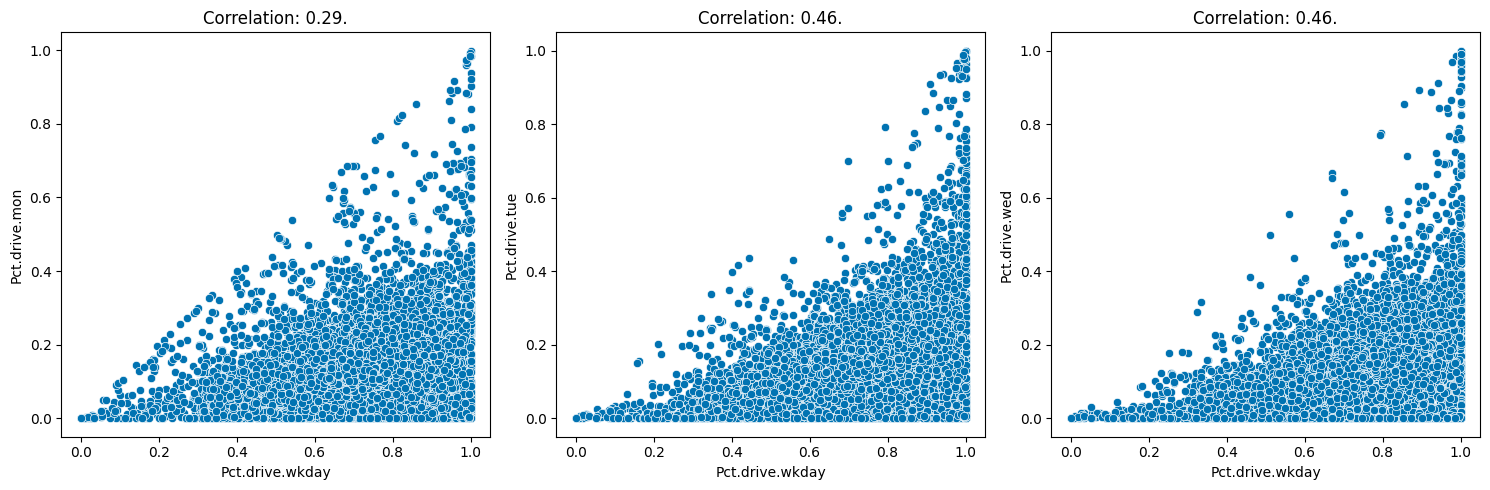

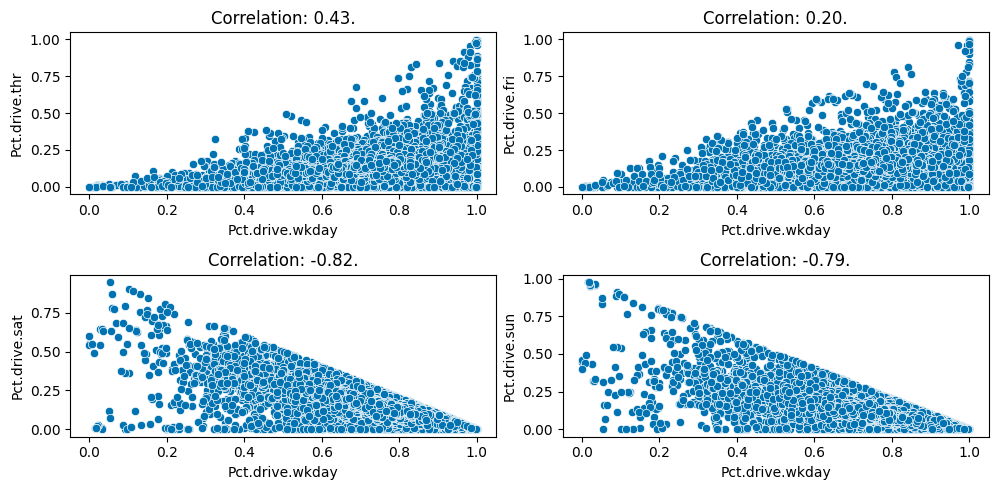

In [121]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(data=df, x='Pct.drive.wkday', y='Pct.drive.mon', ax=ax[0])
ax[0].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkday'], df['Pct.drive.mon'])[0,1])
ax[0].set_xlabel("Pct.drive.wkday")
ax[0].set_ylabel("Pct.drive.mon")

sns.scatterplot(data=df, x='Pct.drive.wkday', y='Pct.drive.tue', ax=ax[1])
ax[1].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkday'], df['Pct.drive.tue'])[0,1])
ax[1].set_xlabel("Pct.drive.wkday")
ax[1].set_ylabel("Pct.drive.tue")

sns.scatterplot(data=df, x='Pct.drive.wkday', y='Pct.drive.wed', ax=ax[2])
ax[2].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkday'], df['Pct.drive.wed'])[0,1])
ax[2].set_xlabel("Pct.drive.wkday")
ax[2].set_ylabel("Pct.drive.wed")

fig1, ax1 = plt.subplots(2, 2, figsize=(10, 5))

sns.scatterplot(data=df, x='Pct.drive.wkday', y='Pct.drive.thr', ax=ax1[0,0])
ax1[0,0].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkday'], df['Pct.drive.thr'])[0,1])
ax1[0,0].set_xlabel("Pct.drive.wkday")
ax1[0,0].set_ylabel("Pct.drive.thr")

sns.scatterplot(data=df, x='Pct.drive.wkday', y='Pct.drive.fri', ax=ax1[0,1])
ax1[0,1].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkday'], df['Pct.drive.fri'])[0,1])
ax1[0,1].set_xlabel("Pct.drive.wkday")
ax1[0,1].set_ylabel("Pct.drive.fri")

sns.scatterplot(data=df, x='Pct.drive.wkday', y='Pct.drive.sat', ax=ax1[1,0])
ax1[1,0].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkday'], df['Pct.drive.sat'])[0,1])
ax1[1,0].set_xlabel("Pct.drive.wkday")
ax1[1,0].set_ylabel("Pct.drive.sat")

sns.scatterplot(data=df, x='Pct.drive.wkday', y='Pct.drive.sun', ax=ax1[1,1])
ax1[1,1].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.wkday'], df['Pct.drive.sun'])[0,1])
ax1[1,1].set_xlabel("Pct.drive.wkday")
ax1[1,1].set_ylabel("Pct.drive.sun")

fig.tight_layout()
fig1.tight_layout()
plt.show()

In [122]:
# Data Error
df[df['Years.noclaims']==df['Insured.age']]

Duration  Insured.age Insured.sex  Car.age  Marital     Car.use  \
25730       366           54      Female       10  Married  Commercial   
30871       366           36        Male       11   Single     Private   
48749       366           66        Male        3  Married     Private   
58595       366           68        Male        3  Married     Private   

       Credit.score Region  Annual.miles.drive  Years.noclaims  ...  \
25730       835.000  Rural           18641.130              54  ...   
30871       770.000  Urban            6213.710              36  ...   
48749       833.000  Urban           12427.420              66  ...   
58595       836.000  Urban           12427.420              68  ...   

       Left.turn.intensity11  Left.turn.intensity12  Right.turn.intensity08  \
25730                  1.000                  1.000                  61.000   
30871                  1.000                  0.000                 199.000   
48749                  0.000                  0.000                 426.000   
58595                  0.000                  0.000                 423.000   

       Right.turn.intensity09  Right.turn.intensity10  Right.turn.intensity11  \
25730                  16.000                   2.000                   1.000   
30871                 104.000                  29.000                  12.000   
48749                 201.000                  88.000                  37.000   
58595                 198.000                  89.000                  39.000   

       Right.turn.intensity12  NB_Claim  AMT_Claim  Pct.drive.rush  
25730                   0.000         0      0.000           0.319  
30871                   1.000         1   4522.391           0.189  
48749                  14.000         0      0.000           0.117  
58595                  14.000         0      0.000           0.100  

[4 rows x 53 columns]

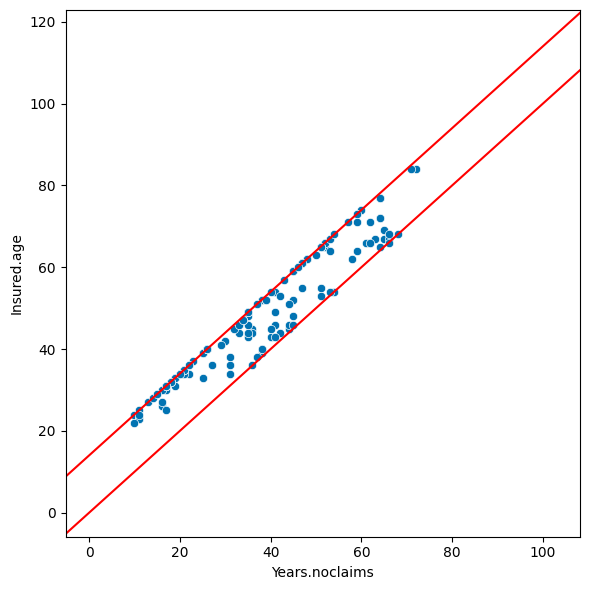

In [123]:
# Year no claims vs Insured Age
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df[df['Years.noclaims']>=df['Insured.age']-14], x='Years.noclaims', y='Insured.age', ax=ax)
ax.axline([0, 0], [103, 103], color='red')
ax.axline([0, 14], [103, 117], color='red')
fig.tight_layout()
plt.show()
# Years no claim == Insured age?? 

In [124]:
df[df['Years.noclaims']>=df['Insured.age']-14]['Insured.age'].describe()

count   142.000
mean     48.563
std      15.121
min      22.000
25%      35.250
50%      46.000
75%      62.750
max      84.000
Name: Insured.age, dtype: float64

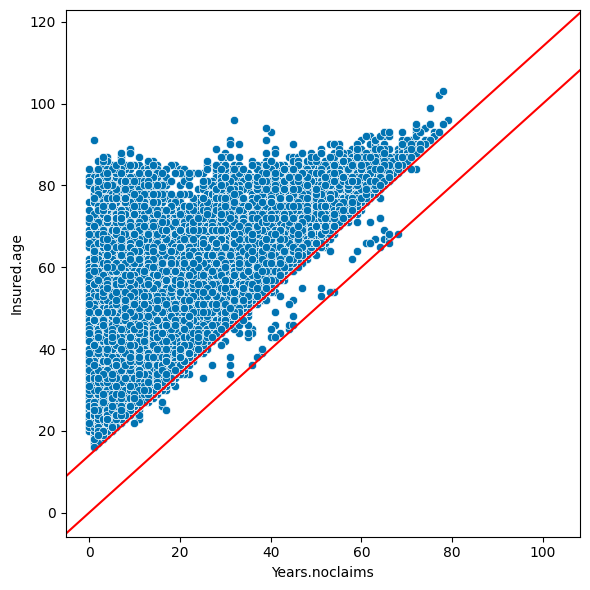

In [125]:
# Year no claims vs Insured Age
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df, x='Years.noclaims', y='Insured.age', ax=ax)
ax.axline([0, 0], [103, 103], color='red')
ax.axline([0, 14], [103, 117], color='red')
fig.tight_layout()
plt.show()
# Years no claim == Insured age?? 

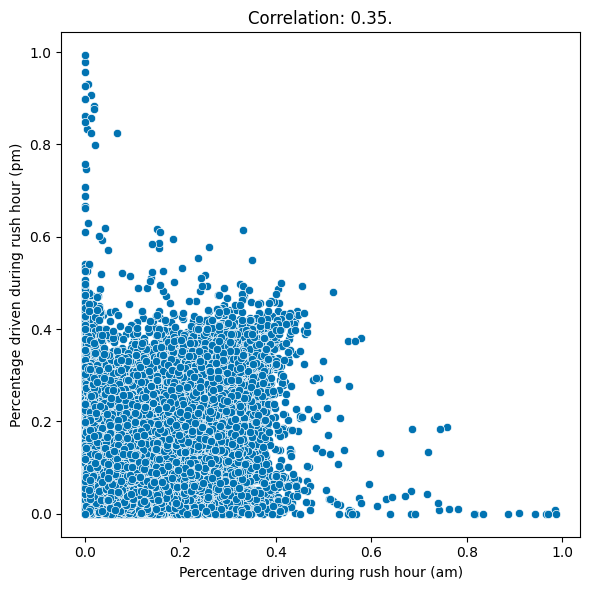

In [126]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df, x='Pct.drive.rush am', y='Pct.drive.rush pm', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.rush am'], df['Pct.drive.rush pm'])[0,1])
ax.set_xlabel("Percentage driven during rush hour (am)")
ax.set_ylabel("Percentage driven during rush hour (pm)")
fig.tight_layout()
plt.show()

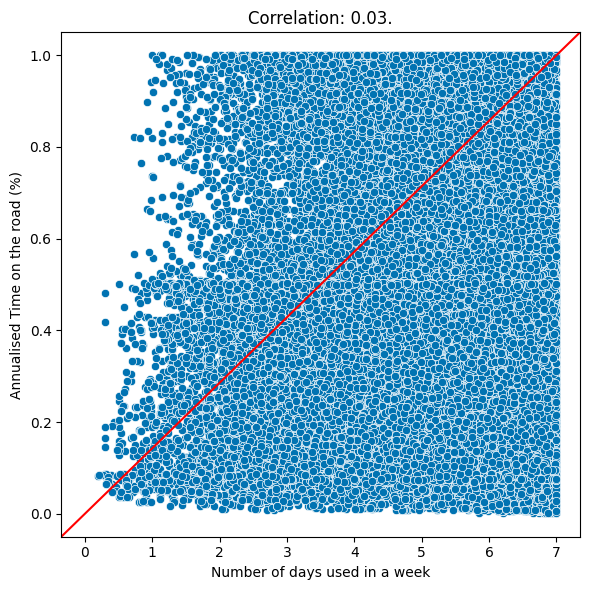

In [127]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df, x='Avgdays.week', y='Annual.pct.driven', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(df['Avgdays.week'], df['Annual.pct.driven'])[0,1])
ax.axline([0, 0], [7, 1], color='red')
ax.set_xlabel("Number of days used in a week")
ax.set_ylabel("Annualised Time on the road (%)")
fig.tight_layout()
plt.show()

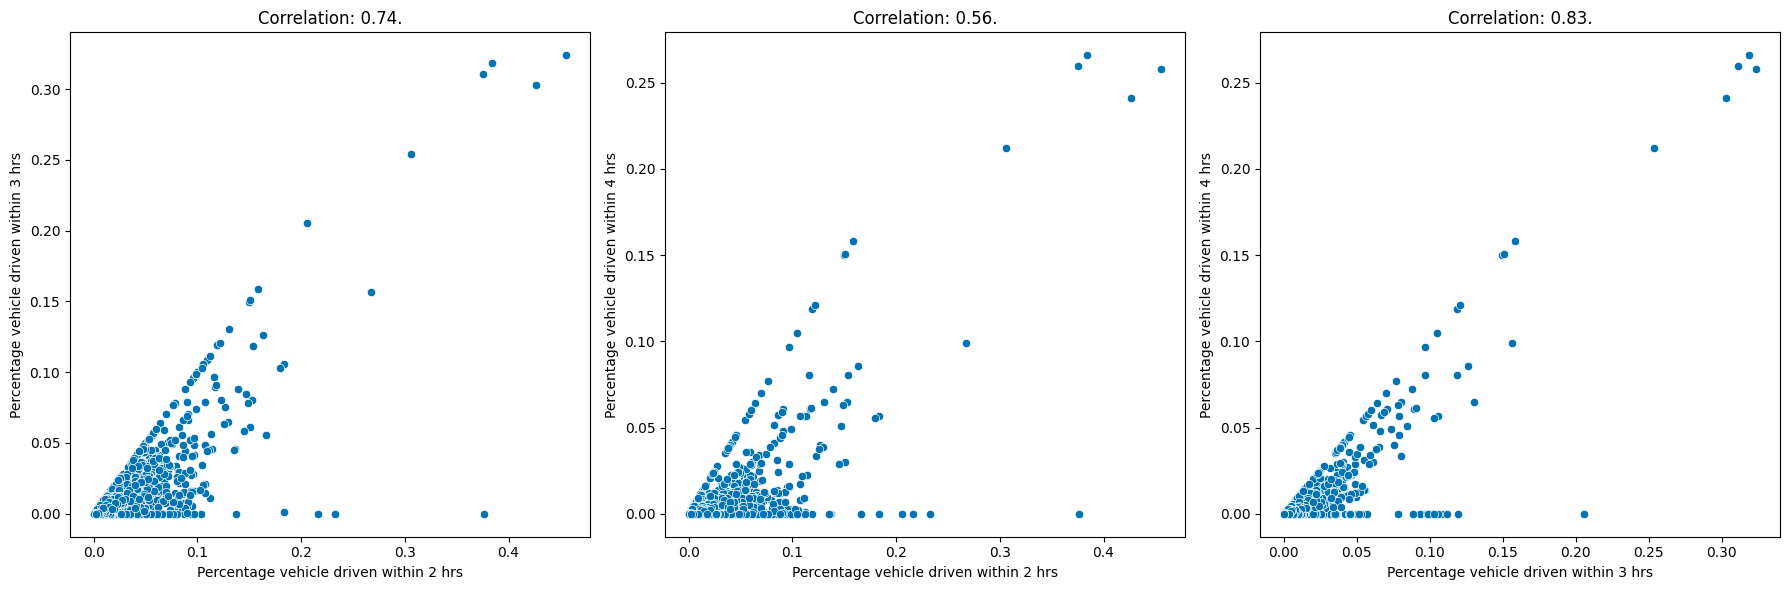

In [128]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=df, x='Pct.drive.2hrs', y='Pct.drive.3hrs', ax=ax[0])
ax[0].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.2hrs'], df['Pct.drive.3hrs'])[0,1])
ax[0].set_xlabel("Percentage vehicle driven within 2 hrs")
ax[0].set_ylabel("Percentage vehicle driven within 3 hrs")

sns.scatterplot(data=df, x='Pct.drive.2hrs', y='Pct.drive.4hrs', ax=ax[1])
ax[1].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.2hrs'], df['Pct.drive.4hrs'])[0,1])
ax[1].set_xlabel("Percentage vehicle driven within 2 hrs")
ax[1].set_ylabel("Percentage vehicle driven within 4 hrs")

sns.scatterplot(data=df, x='Pct.drive.3hrs', y='Pct.drive.4hrs', ax=ax[2])
ax[2].set_title('Correlation: %.2f.' %np.corrcoef(df['Pct.drive.3hrs'], df['Pct.drive.4hrs'])[0,1])
ax[2].set_xlabel("Percentage vehicle driven within 3 hrs")
ax[2].set_ylabel("Percentage vehicle driven within 4 hrs")
fig.tight_layout()
plt.show()

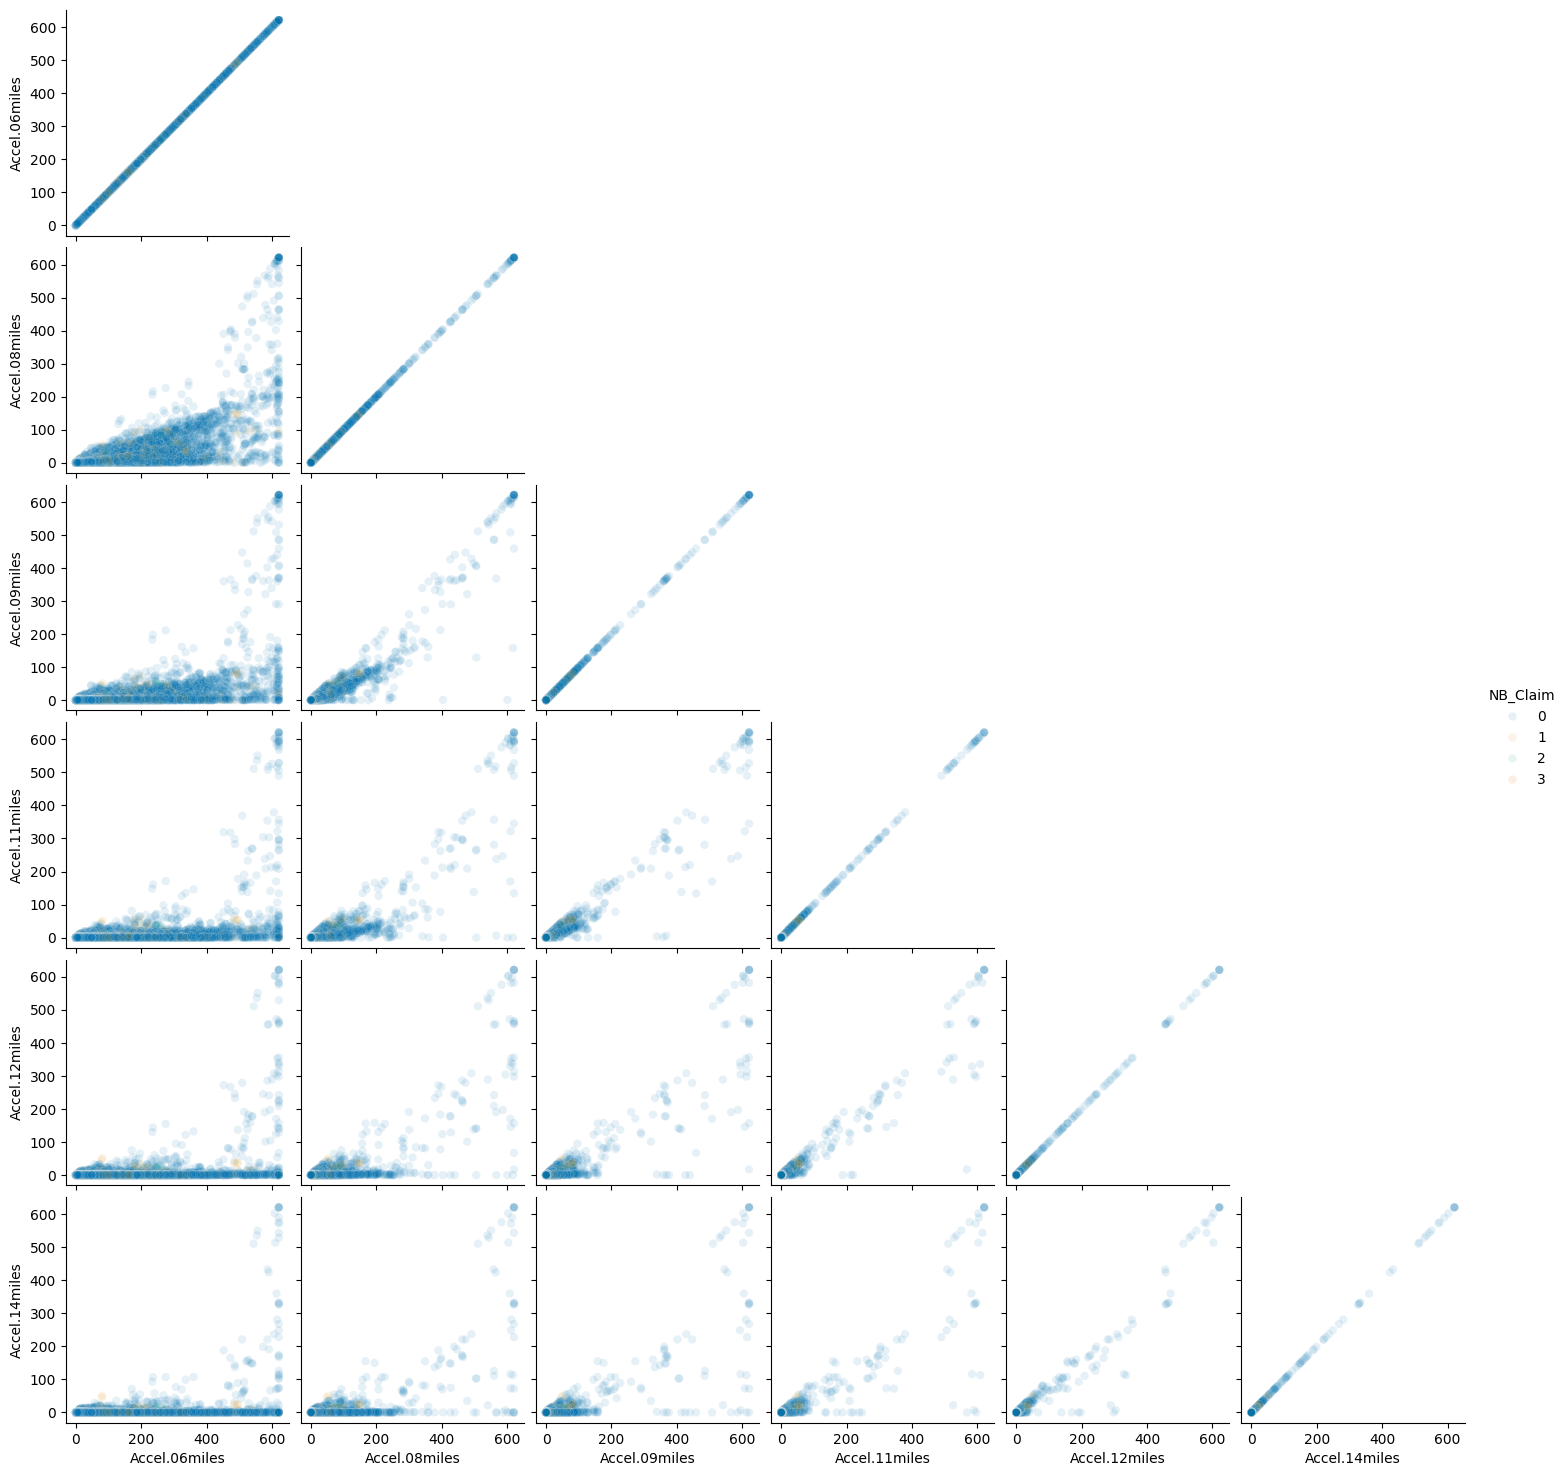

In [129]:
sns.pairplot(data=df, vars=['Accel.06miles','Accel.08miles','Accel.09miles','Accel.11miles','Accel.12miles','Accel.14miles'], 
             diag_kind=None, corner=True, palette='colorblind', plot_kws={'alpha': 0.1},
             hue='NB_Claim')
plt.show()

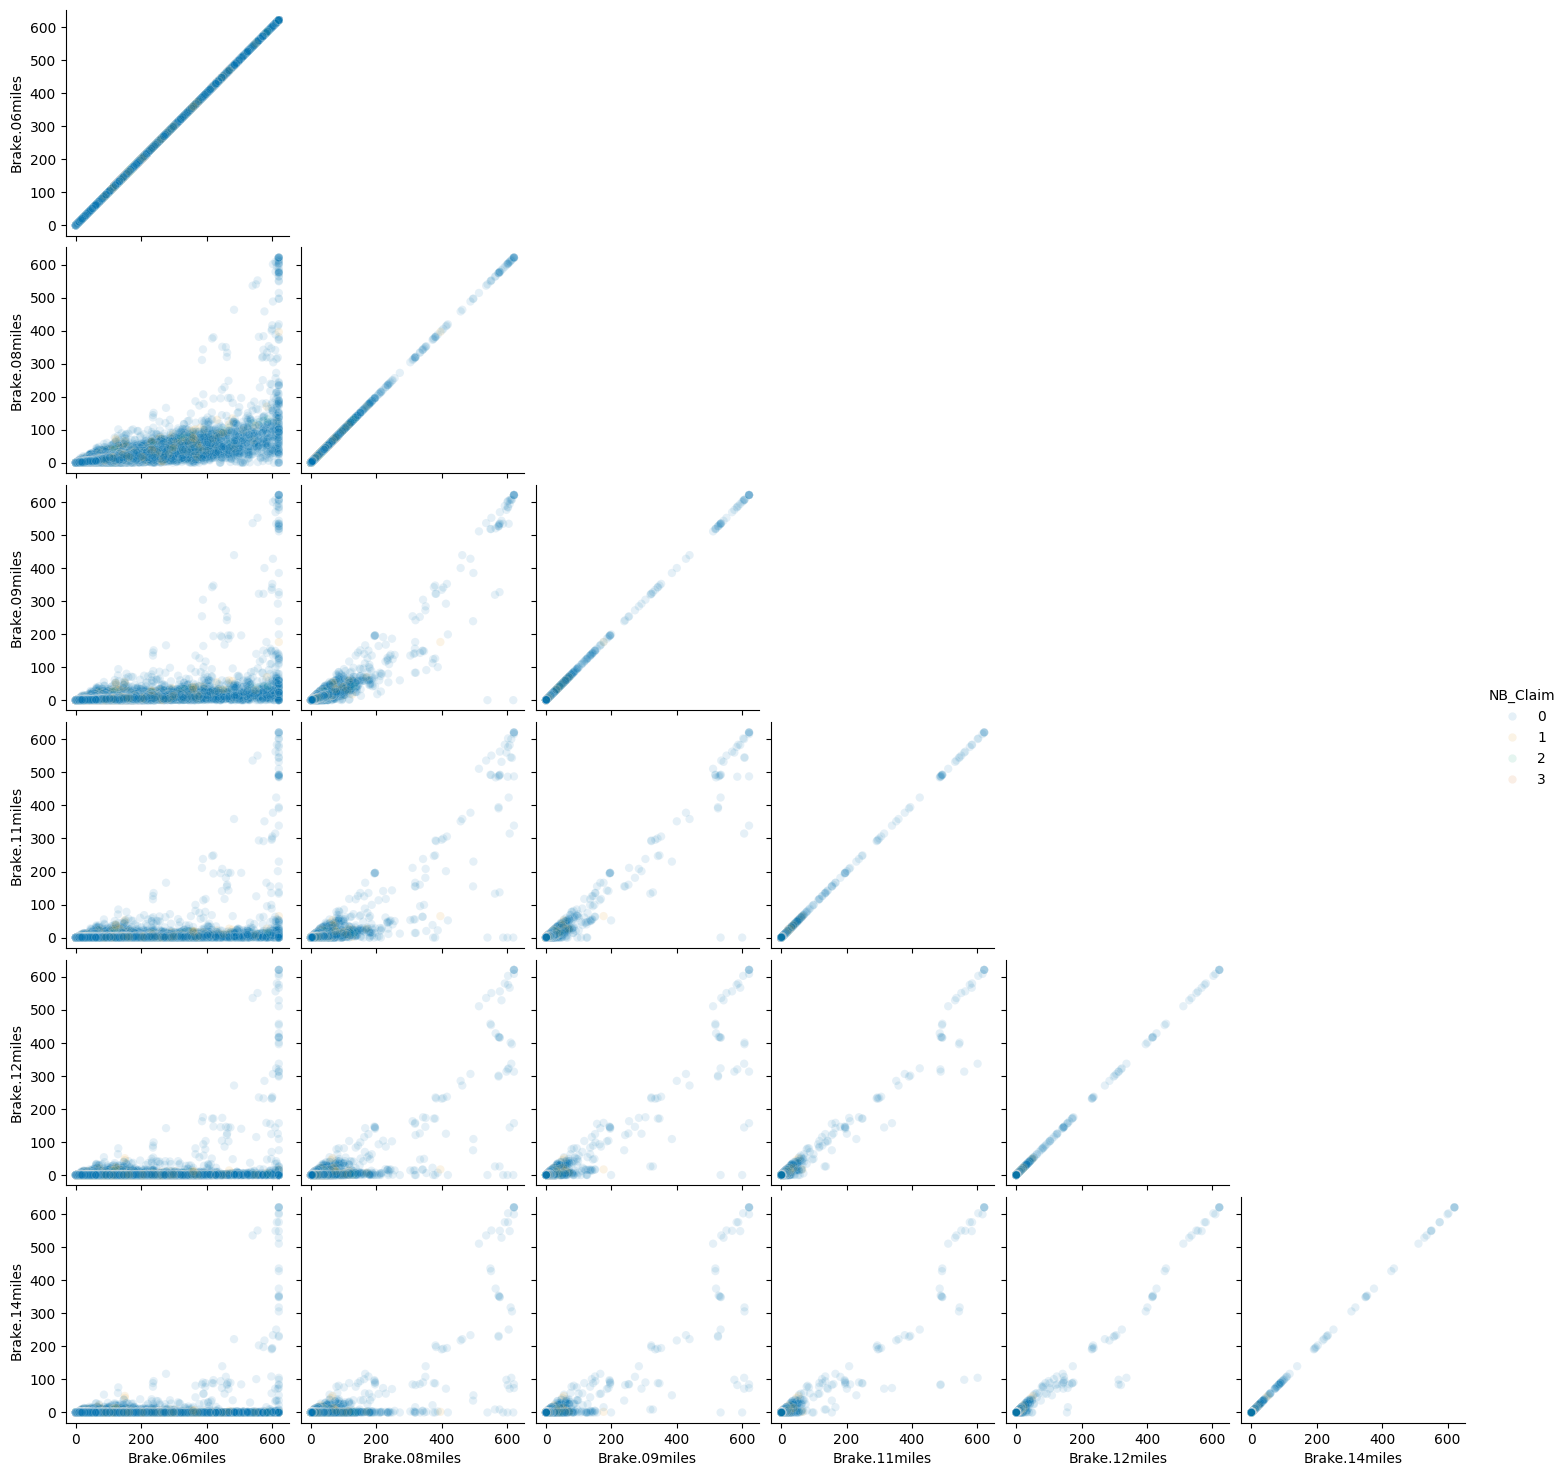

In [130]:
sns.pairplot(data=df, vars=['Brake.06miles','Brake.08miles','Brake.09miles','Brake.11miles','Brake.12miles','Brake.14miles'], 
             diag_kind=None, corner=True, palette='colorblind', plot_kws={'alpha': 0.1},
             hue='NB_Claim')
plt.show()

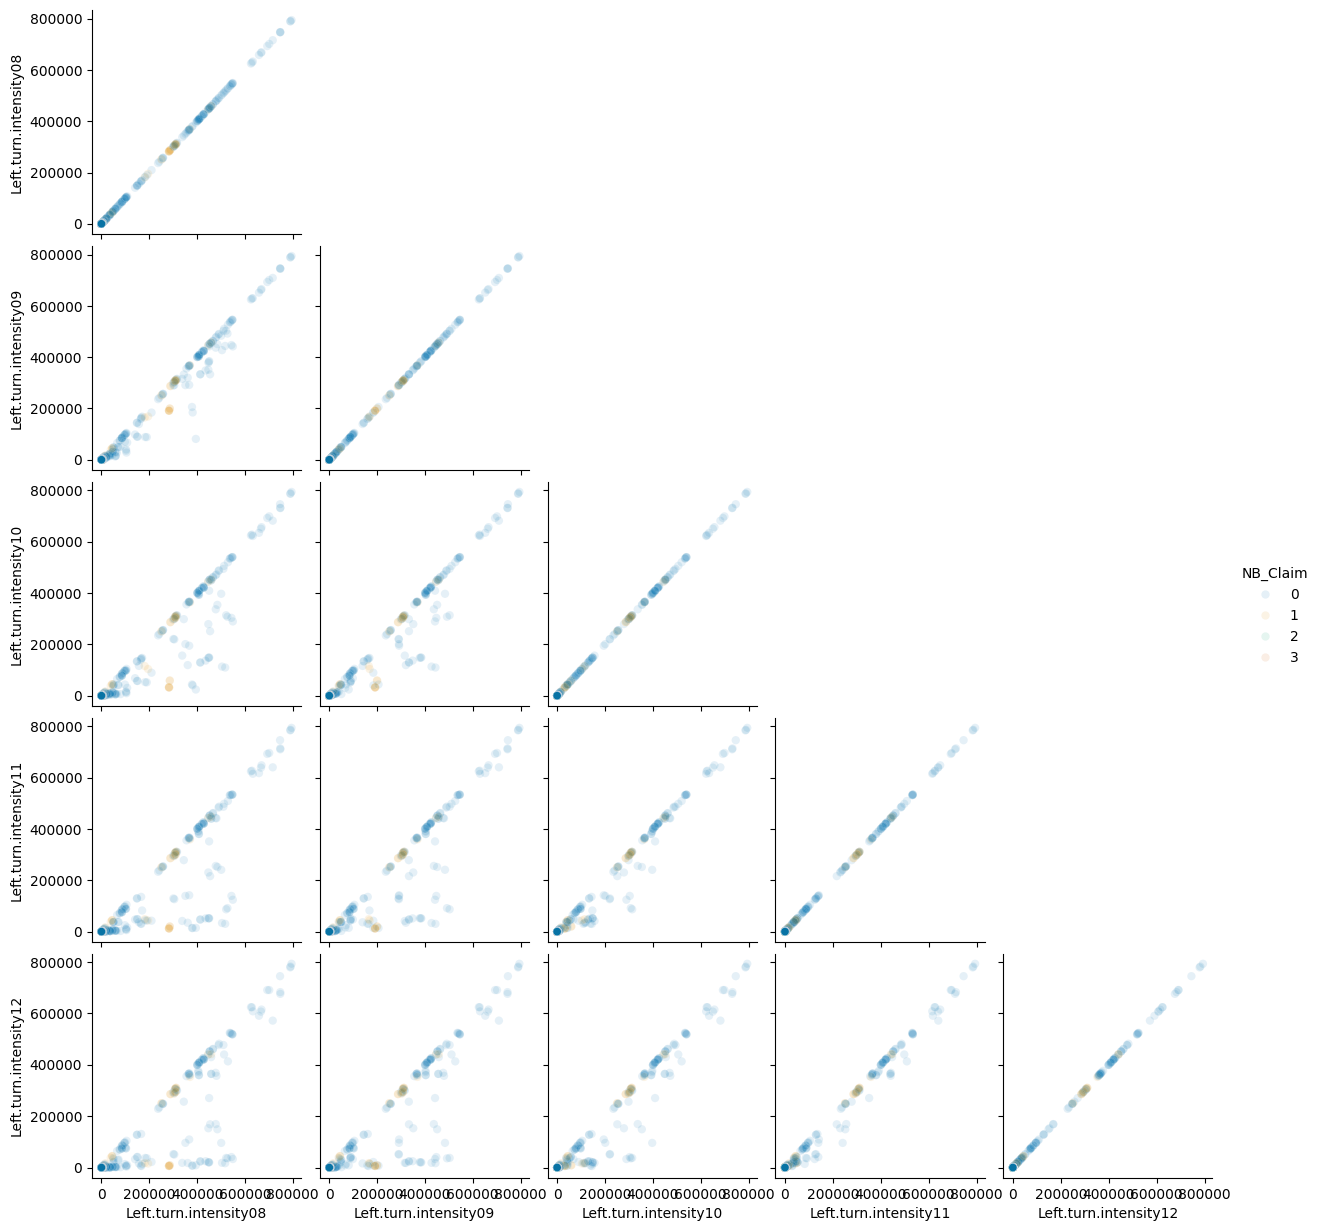

In [131]:
sns.pairplot(data=df, vars=['Left.turn.intensity08', 'Left.turn.intensity09', 'Left.turn.intensity10', 'Left.turn.intensity11', 'Left.turn.intensity12'], 
             diag_kind=None, corner=True, palette='colorblind', plot_kws={'alpha': 0.1},
             hue='NB_Claim')
plt.show()

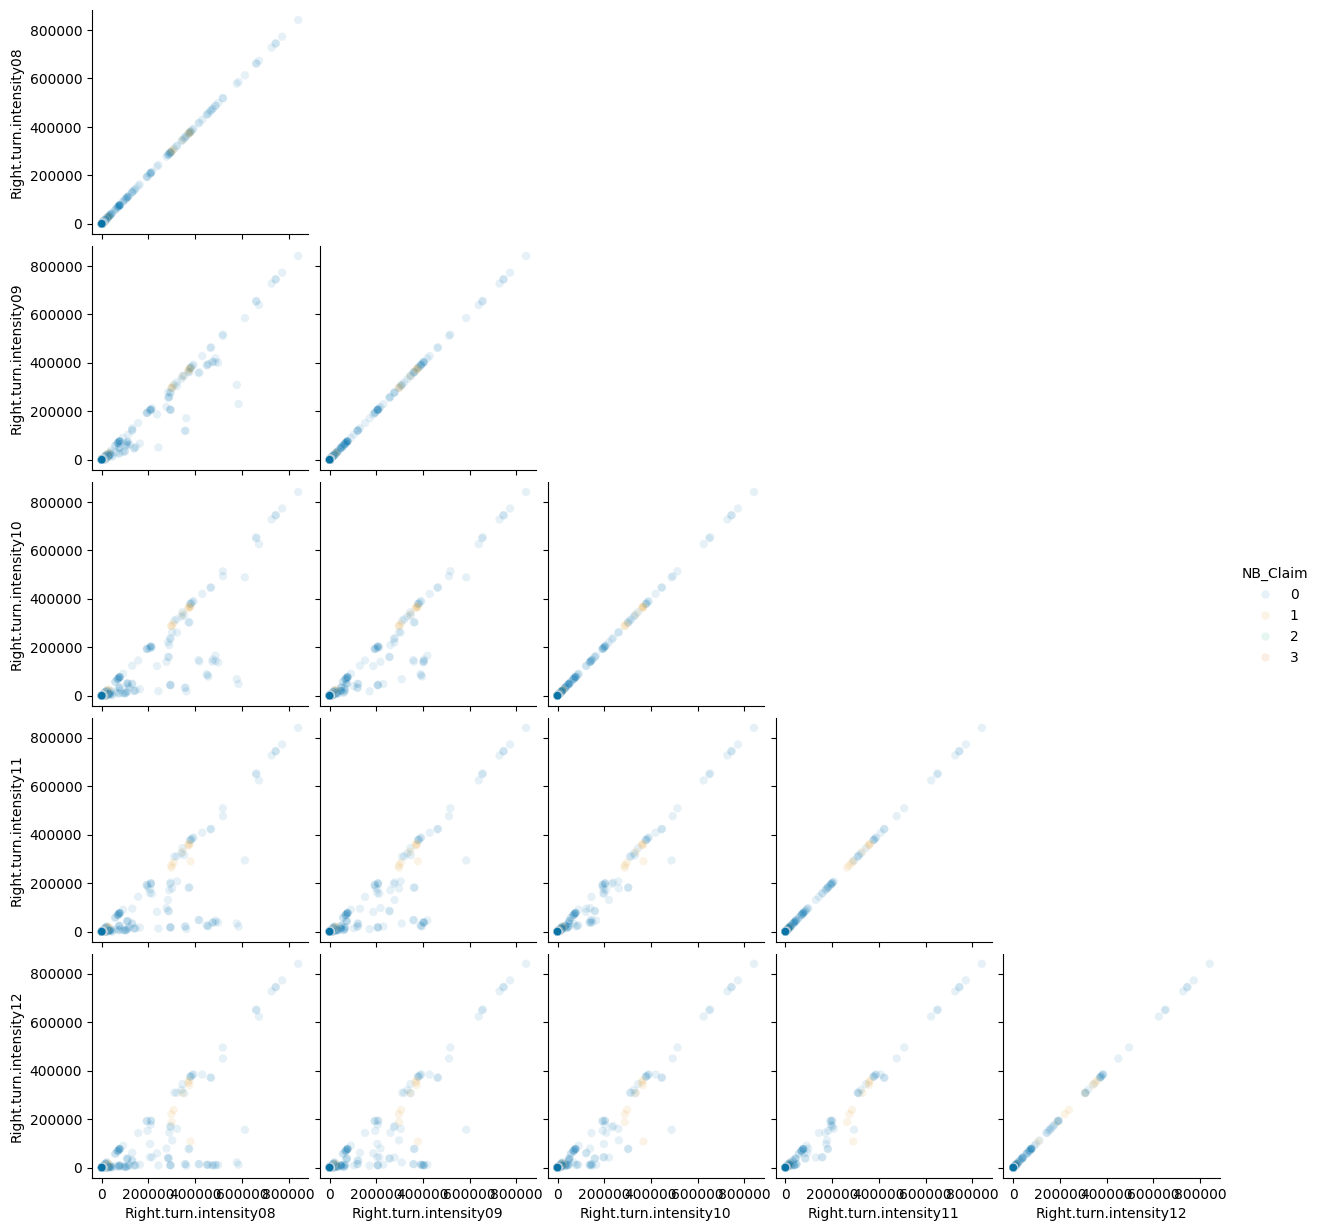

In [132]:
sns.pairplot(data=df, vars=['Right.turn.intensity08', 'Right.turn.intensity09', 'Right.turn.intensity10', 'Right.turn.intensity11', 'Right.turn.intensity12'], 
             diag_kind=None, corner=True, palette='colorblind', plot_kws={'alpha': 0.1},
             hue='NB_Claim')
plt.show()

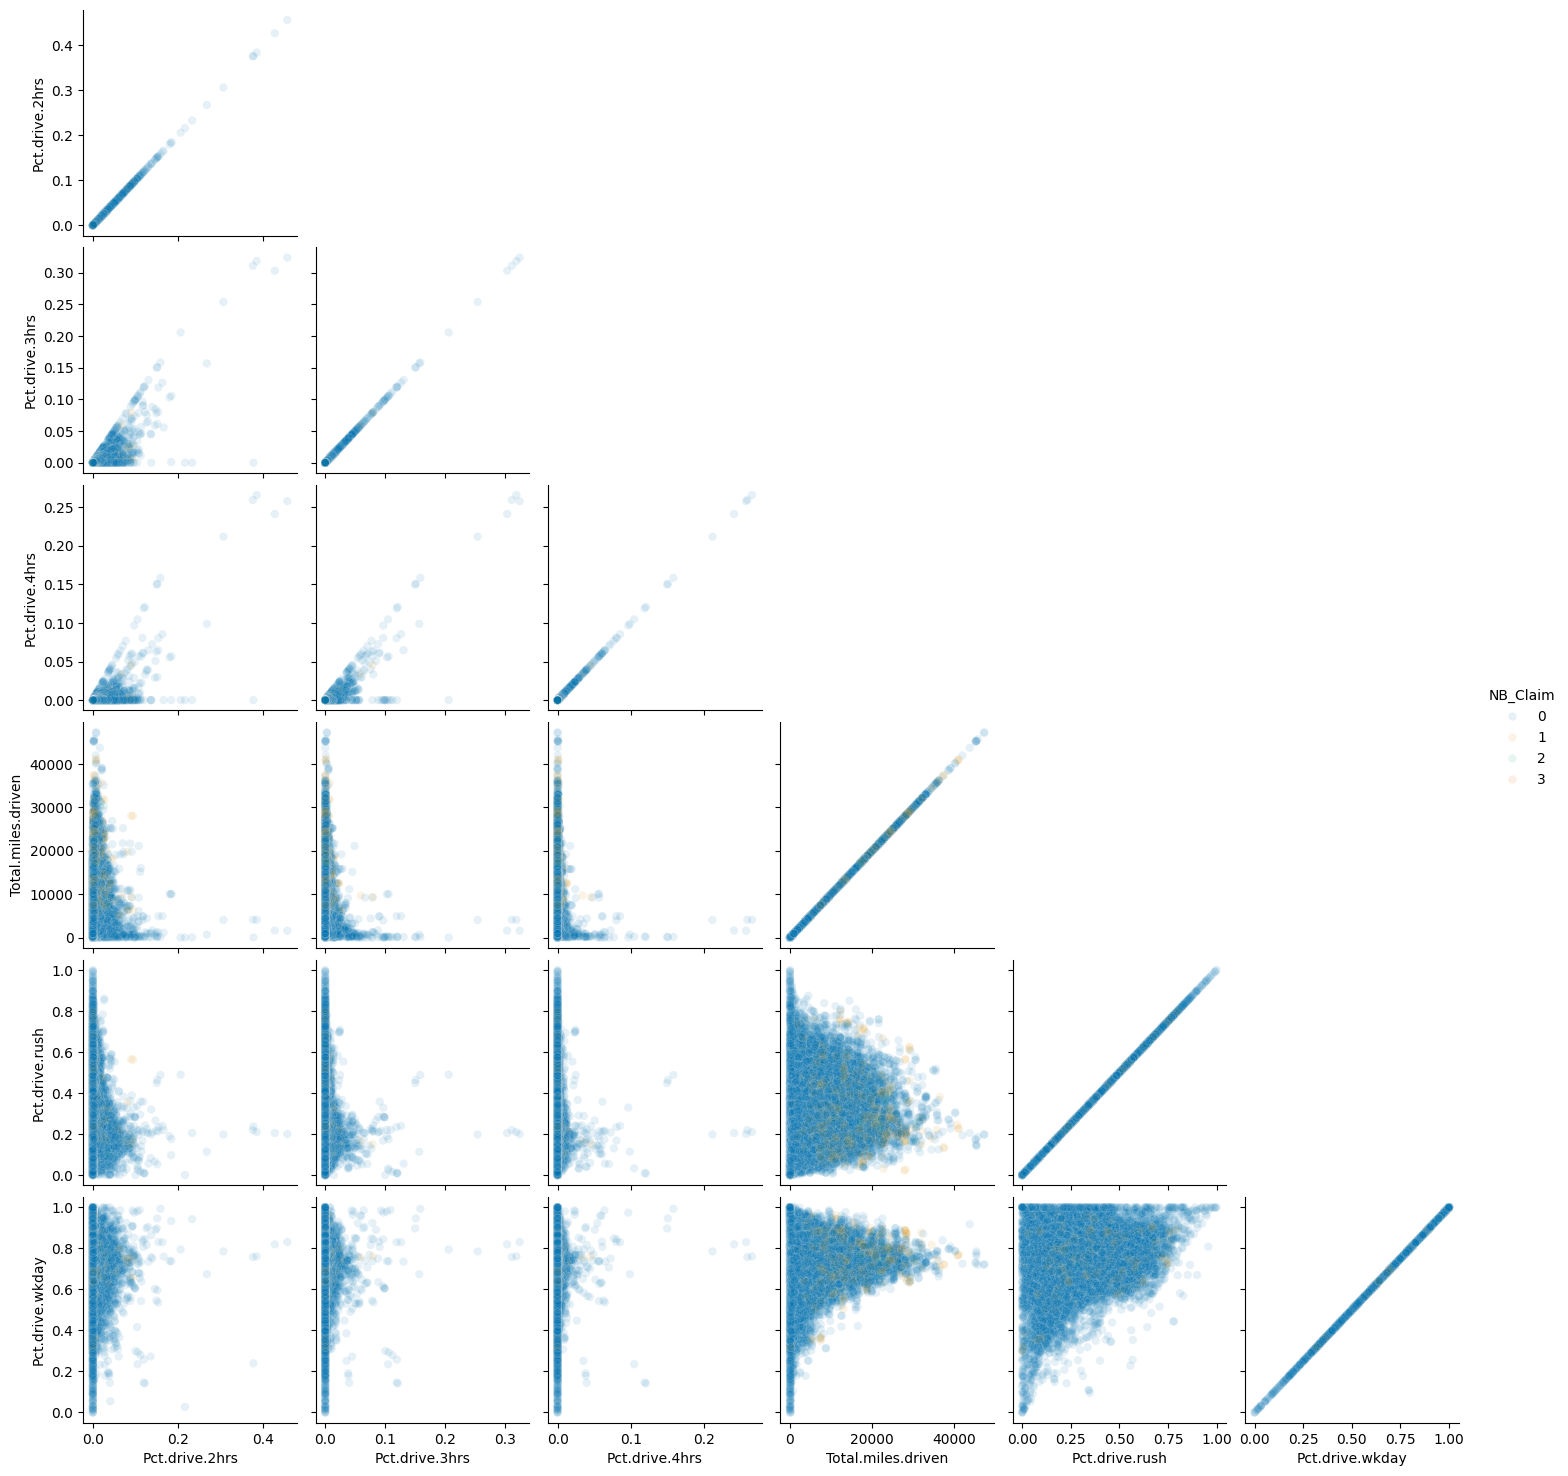

In [133]:
sns.pairplot(data=df, vars=['Pct.drive.2hrs', 'Pct.drive.3hrs', 'Pct.drive.4hrs', 'Total.miles.driven', 'Pct.drive.rush', 'Pct.drive.wkday'], 
             diag_kind=None, corner=True, palette='colorblind', plot_kws={'alpha': 0.1},
             hue='NB_Claim')
plt.show()

# Clean data

In [134]:
clean_df = pd.read_csv("../data/telematics_clean.csv")

In [135]:
clean_df.columns

Index(['Duration', 'Insured_age', 'Car_age', 'Credit_score',
       'Annual_miles_drive', 'Years_noclaims', 'Territory_nominal',
       'Annual_pct_driven', 'Total_miles_driven', 'Pct_drive_mon',
       'Pct_drive_tue', 'Pct_drive_wed', 'Pct_drive_thr', 'Pct_drive_fri',
       'Pct_drive_sat', 'Pct_drive_sun', 'Pct_drive_2hrs', 'Pct_drive_3hrs',
       'Pct_drive_4hrs', 'Pct_drive_wkday', 'Pct_drive_wkend',
       'Pct_drive_rush_am', 'Pct_drive_rush_pm', 'Avgdays_week',
       'Accel_06miles', 'Accel_08miles', 'Accel_09miles', 'Accel_11miles',
       'Accel_12miles', 'Accel_14miles', 'Brake_06miles', 'Brake_08miles',
       'Brake_09miles', 'Brake_11miles', 'Brake_12miles', 'Brake_14miles',
       'Left_turn_intensity08', 'Left_turn_intensity09',
       'Left_turn_intensity10', 'Left_turn_intensity11',
       'Left_turn_intensity12', 'Right_turn_intensity08',
       'Right_turn_intensity09', 'Right_turn_intensity10',
       'Right_turn_intensity11', 'Right_turn_intensity12', 'NB_Claim

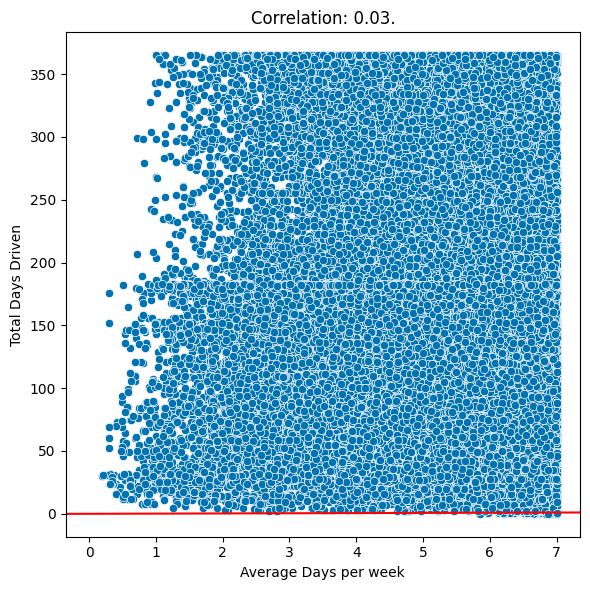

In [137]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=clean_df, x='Avgdays_week', y='Total_days_driven', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(clean_df['Avgdays_week'], clean_df['Total_days_driven'])[0,1])
ax.axline([0, 0], [7, 1], color='red')
ax.set_xlabel("Average Days per week")
ax.set_ylabel("Total Days Driven")
fig.tight_layout()
plt.show()

In [138]:
clean_df['Total_days_driven'].describe()

count   100000.000
mean       182.900
std        109.277
min          0.000
25%         90.000
50%        179.000
75%        275.000
max        365.000
Name: Total_days_driven, dtype: float64

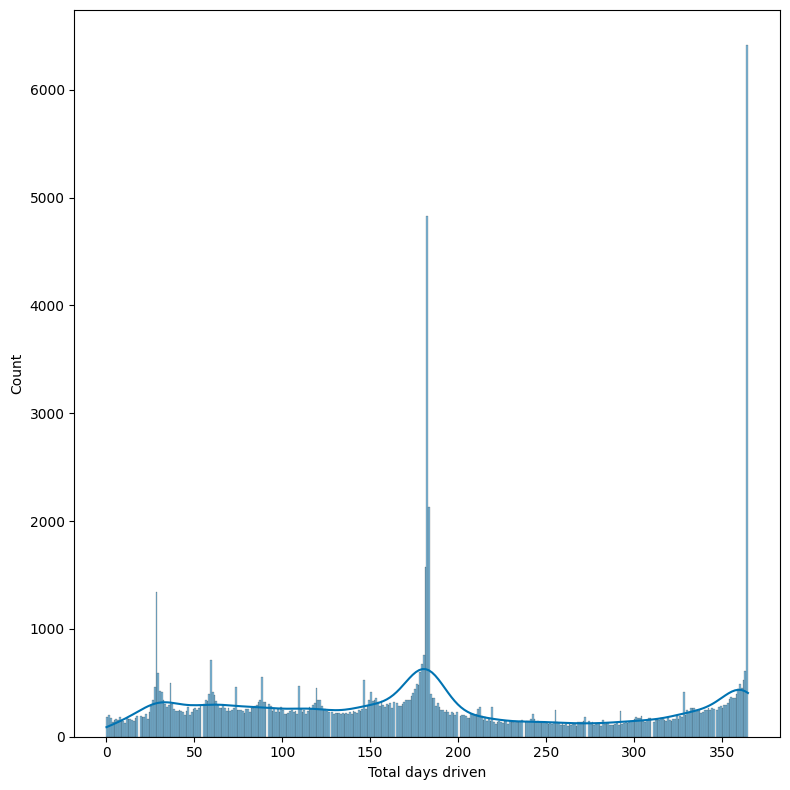

In [139]:
fig, ax = plt.subplots(figsize=(8, 8))
unique_values = np.arange(clean_df['Total_days_driven'].min(), clean_df['Total_days_driven'].max() + 1)
sns.histplot(ax=ax, data=clean_df, x='Total_days_driven', bins=unique_values, kde=True)
ax.set_xlabel("Total days driven")
ax.set_ylabel("Count")
fig.tight_layout()
plt.show()

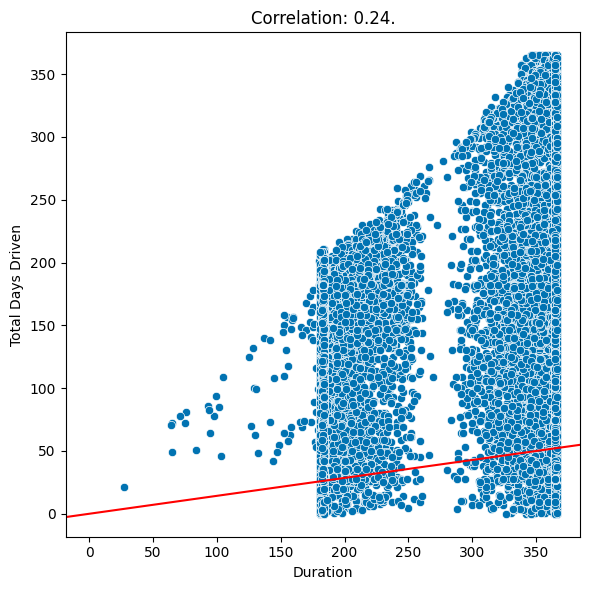

In [140]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=clean_df, x='Duration', y='Total_days_driven', ax=ax)
ax.set_title('Correlation: %.2f.' %np.corrcoef(clean_df['Duration'], clean_df['Total_days_driven'])[0,1])
ax.axline([0, 0], [7, 1], color='red')
ax.set_xlabel("Duration")
ax.set_ylabel("Total Days Driven")
fig.tight_layout()
plt.show()

In [141]:
sum(clean_df['Duration'] >= clean_df['Total_days_driven'])/clean_df.shape[0]

0.97722

# Claim frequency

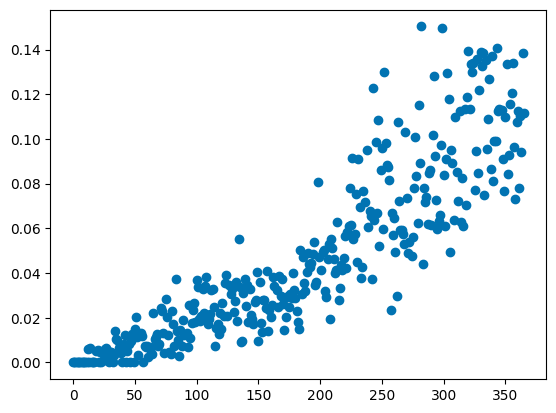

In [142]:
plt.scatter(clean_df.groupby('Total_days_driven').mean().index,
         clean_df.groupby('Total_days_driven').mean()['NB_Claim'])
plt.show()

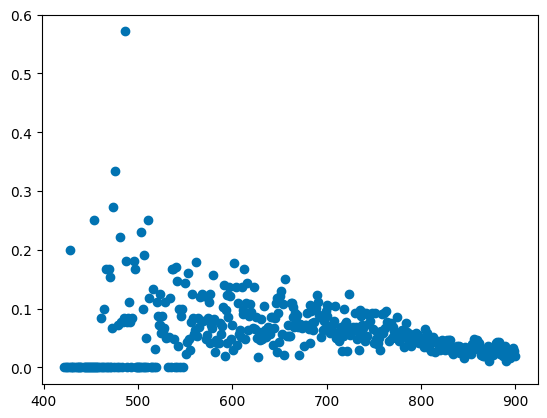

In [143]:
plt.scatter(clean_df.groupby('Credit_score').mean().index,
         clean_df.groupby('Credit_score').mean()['NB_Claim'])

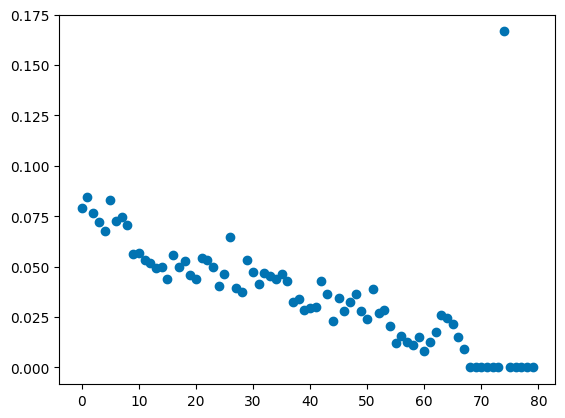

In [144]:
plt.scatter(clean_df.groupby('Years_noclaims').mean().index,
         clean_df.groupby('Years_noclaims').mean()['NB_Claim'])

In [145]:
clean_df['Total_miles_driven'].max()

47282.603935729785

In [146]:
binned_data = clean_df.copy()
binned_data['bins'] = pd.cut(binned_data['Total_miles_driven'], bins=range(0, 48000, 1000))
binned_data.groupby('bins')['NB_Claim'].mean()

/var/folders/kb/rz2pm09x1jzbrrpsy5ffp3cc0000gn/T/ipykernel_6062/599650307.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data.groupby('bins')['NB_Claim'].mean()


bins
(0, 1000]        0.005
(1000, 2000]     0.011
(2000, 3000]     0.018
(3000, 4000]     0.034
(4000, 5000]     0.042
(5000, 6000]     0.054
(6000, 7000]     0.063
(7000, 8000]     0.084
(8000, 9000]     0.089
(9000, 10000]    0.109
(10000, 11000]   0.117
(11000, 12000]   0.112
(12000, 13000]   0.098
(13000, 14000]   0.142
(14000, 15000]   0.123
(15000, 16000]   0.094
(16000, 17000]   0.110
(17000, 18000]   0.164
(18000, 19000]   0.136
(19000, 20000]   0.073
(20000, 21000]   0.190
(21000, 22000]   0.250
(22000, 23000]   0.167
(23000, 24000]   0.217
(24000, 25000]   0.197
(25000, 26000]   0.128
(26000, 27000]   0.088
(27000, 28000]   0.265
(28000, 29000]   0.354
(29000, 30000]   0.238
(30000, 31000]   0.250
(31000, 32000]   0.150
(32000, 33000]   0.062
(33000, 34000]   0.000
(34000, 35000]   0.200
(35000, 36000]   0.091
(36000, 37000]   0.200
(37000, 38000]   0.667
(38000, 39000]   0.000
(39000, 40000]   0.000
(40000, 41000]   0.500
(41000, 42000]   0.500
(42000, 43000]     NaN
(43000

In [147]:
np.arange(500, 48500, 1000)

array([  500,  1500,  2500,  3500,  4500,  5500,  6500,  7500,  8500,
        9500, 10500, 11500, 12500, 13500, 14500, 15500, 16500, 17500,
       18500, 19500, 20500, 21500, 22500, 23500, 24500, 25500, 26500,
       27500, 28500, 29500, 30500, 31500, 32500, 33500, 34500, 35500,
       36500, 37500, 38500, 39500, 40500, 41500, 42500, 43500, 44500,
       45500, 46500, 47500])

/var/folders/kb/rz2pm09x1jzbrrpsy5ffp3cc0000gn/T/ipykernel_6062/1212631522.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data.groupby('bins').mean()['NB_Claim'])


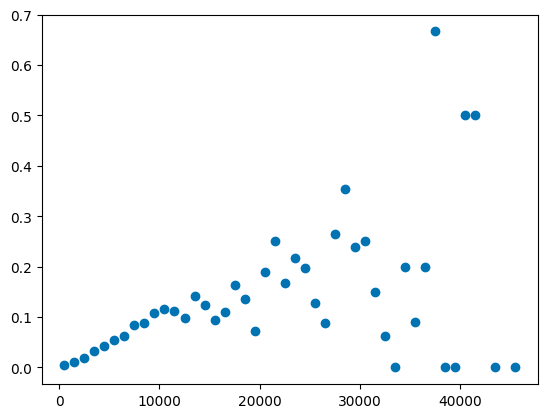

In [148]:
plt.scatter(np.arange(500, 47000, 1000),
         binned_data.groupby('bins').mean()['NB_Claim'])